# Predictive Demand Forecasting Using Machine Learning to Reduce Food Waste
## Chapter 4: Results and Discussion

**Models Compared:**
- **Random Forest (RF)** — Robust ensemble baseline
- **XGBoost** — Gradient-boosted trees, optimised for speed
- **LSTM** — Deep Learning RNN for complex time-series patterns

**Evaluation Metrics:** RMSE, MAPE

**Strategy:** Loop through every unique commodity, train all three models, identify the champion model per crop.

---

In [ ]:
# ============================================================
# Cell 1: Install Required Packages
# ============================================================
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn tensorflow

import warnings
warnings.filterwarnings('ignore')
print('All packages installed successfully.')

All packages installed successfully.


In [ ]:
# ============================================================
# Cell 2: Import Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# XGBoost
from xgboost import XGBRegressor

# TensorFlow / Keras (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# Cell 3: Load Data
# ============================================================
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/harmonized_food_prices.csv')

print(f"\nLoaded CSV file with {len(df):,} rows and {len(df.columns)} columns.")
print(f'\nColumns: {list(df.columns)}')
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
df.head(10)


Loaded CSV file with 55,077 rows and 17 columns.

Columns: ['Date', 'Demand', 'Commodity_Name', 'Market_Location', 'Unit_Price', 'Avg_Temperature', 'Rainfall', 'Is_Holiday', 'State', 'LGA', 'Latitude', 'Longitude', 'Category', 'Unit', 'Price_Type', 'Currency', 'Price_USD']

Date range: 2002-01-15 to 2025-11-15


Date  Demand   Commodity_Name              Market_Location  \
0  2002-01-15    0.16           Millet  Jibia (CBM), Jibia, Katsina   
1  2002-01-15    2.46          Sorghum  Jibia (CBM), Jibia, Katsina   
2  2002-01-15   40.29            Maize   Illela (CBM), Gada, Sokoto   
3  2002-01-15    0.34  Rice (imported)   Illela (CBM), Gada, Sokoto   
4  2002-02-15   48.24            Maize  Jibia (CBM), Jibia, Katsina   
5  2002-02-15    0.16           Millet  Jibia (CBM), Jibia, Katsina   
6  2002-02-15    2.55          Sorghum  Jibia (CBM), Jibia, Katsina   
7  2002-03-15    0.22           Millet  Jibia (CBM), Jibia, Katsina   
8  2002-03-15    0.40  Rice (imported)  Jibia (CBM), Jibia, Katsina   
9  2002-03-15    2.91          Sorghum  Jibia (CBM), Jibia, Katsina   

   Unit_Price  Avg_Temperature  Rainfall  Is_Holiday    State    LGA  \
0      150.18             18.5       0.0           0  Katsina  Jibia   
1      155.61             18.5       0.0           0  Katsina  Jibia   
2      153.35             19.9       0.0           0   Sokoto   Gada   
3      337.59             19.9       0.0           0   Sokoto   Gada   
4      169.76             22.5       0.0           0  Katsina  Jibia   
5      148.54             22.5       0.0           0  Katsina  Jibia   
6      159.15             22.5       0.0           0  Katsina  Jibia   
7      175.00             30.7       0.0           0  Katsina  Jibia   
8      361.11             30.7       0.0           0  Katsina  Jibia   
9      172.22             30.7       0.0           0  Katsina  Jibia   

   Latitude  Longitude            Category Unit Price_Type Currency  Price_USD  
0     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.31  
1     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.36  
2     13.64       5.28  cereals and tubers   KG  Wholesale      NGN       1.34  
3     13.64       5.28  cereals and tubers   KG  Wholesale      NGN       2.95  
4     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.42  
5     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.24  
6     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.33  
7     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.50  
8     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       3.09  
9     13.08       7.24  cereals and tubers   KG  Wholesale      NGN       1.47

## 1. Exploratory Data Analysis

In [ ]:
# ============================================================
# Cell 4: Dataset Overview
# ============================================================
print('=' * 60)
print('DATASET OVERVIEW')
print('=' * 60)

print(f'\nShape: {df.shape}')
print(f'\nData Types:')
print(df.dtypes)
print(f'\nMissing Values:')
print(df.isnull().sum())
print(f'\nBasic Statistics:')
df.describe()

DATASET OVERVIEW

Shape: (55077, 17)

Data Types:
Date                object
Demand             float64
Commodity_Name      object
Market_Location     object
Unit_Price         float64
Avg_Temperature    float64
Rainfall           float64
Is_Holiday           int64
State               object
LGA                 object
Latitude           float64
Longitude          float64
Category            object
Unit                object
Price_Type          object
Currency            object
Price_USD          float64
dtype: object

Missing Values:
Date                   0
Demand                 0
Commodity_Name         0
Market_Location        0
Unit_Price             0
Avg_Temperature    17703
Rainfall           17703
Is_Holiday             0
State                  0
LGA                    0
Latitude               0
Longitude              0
Category               0
Unit                   0
Price_Type             0
Currency               0
Price_USD              0
dtype: int64

Basic Statistics:


Demand     Unit_Price  Avg_Temperature      Rainfall  \
count  55077.000000   55077.000000     37374.000000  37374.000000   
mean      18.232701    5193.731455        26.741398      1.953283   
std       20.359193   10251.149844         3.279671      4.825670   
min        0.000000       1.000000        17.100000      0.000000   
25%        2.790000     253.640000        24.400000      0.000000   
50%       10.170000     847.100000        26.500000      0.000000   
75%       27.420000    4066.670000        28.700000      1.100000   
max      100.000000  138000.000000        36.200000     76.100000   

         Is_Holiday      Latitude     Longitude     Price_USD  
count  55077.000000  55077.000000  55077.000000  55077.000000  
mean       0.026399     11.512835     10.737463     15.116709  
std        0.160321      1.558722      2.840651     30.158834  
min        0.000000      5.150000      3.400000      0.002300  
25%        0.000000     11.290000      8.680000      0.720000  
50%        0.000000     11.830000     11.540000      1.790000  
75%        0.000000     12.490000     13.150000      4.300000  
max        1.000000     13.640000     14.490000    453.170000

Unique Commodities: 42

Commodity_Name
Millet                         3165
Rice (imported)                2785
Rice (local)                   2610
Yam                            2407
Oil (palm)                     2032
Sorghum                        1686
Sorghum (white)                1633
Maize (white)                  1574
Cowpeas (white)                1447
Sorghum (brown)                1420
Cowpeas (brown)                1389
Groundnuts (shelled)           1382
Maize (yellow)                 1376
Meat (beef)                    1359
Beans (white)                  1354
Fish                           1352
Gari (white)                   1333
Eggs                           1326
Oil (vegetable)                1322
Beans (red)                    1320
Groundnuts                     1317
Watermelons                    1301
Milk (powder)                  1295
Oranges                        1294
Maize flour                    1290
Meat (goat)                    1268
Onions                   

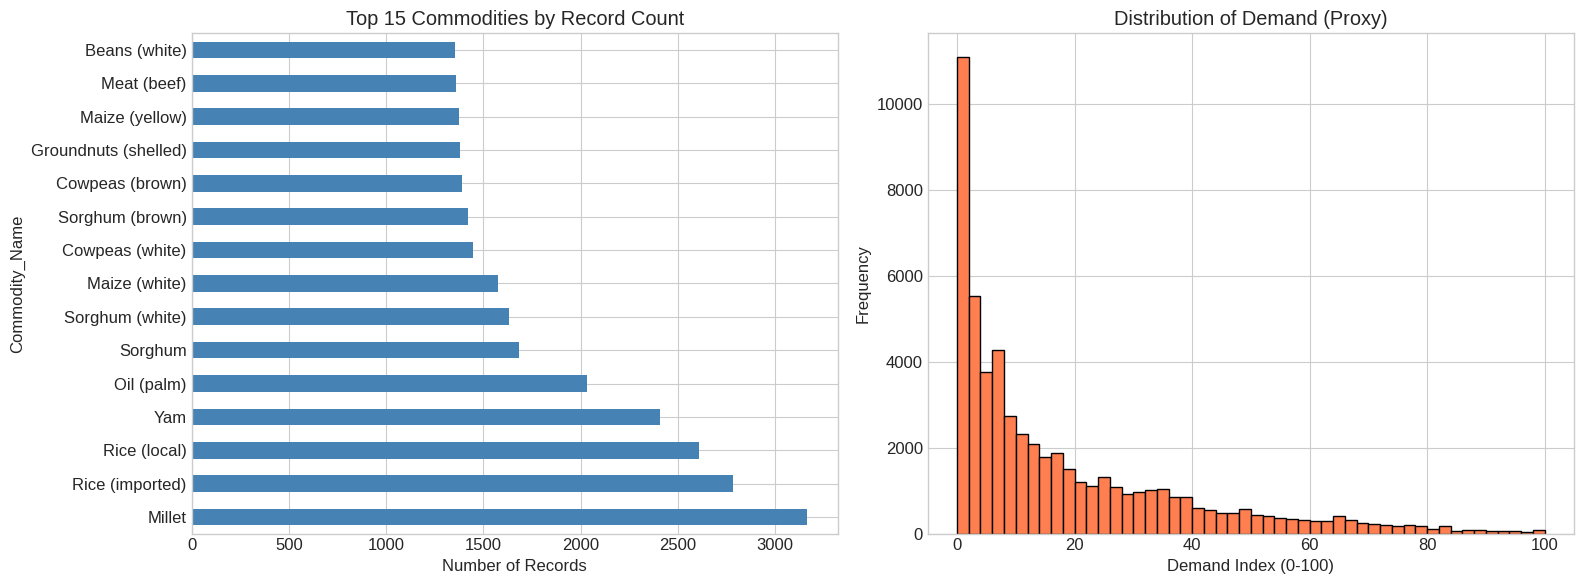

In [ ]:
# ============================================================
# Cell 5: Commodity Distribution & Demand Overview
# ============================================================
commodity_counts = df['Commodity_Name'].value_counts()
print(f'Unique Commodities: {len(commodity_counts)}\n')
print(commodity_counts.to_string())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 commodities by record count
commodity_counts.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Commodities by Record Count')
axes[0].set_xlabel('Number of Records')

# Demand distribution
df['Demand'].hist(bins=50, ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Distribution of Demand (Proxy)')
axes[1].set_xlabel('Demand Index (0-100)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Steps:
1. Aggregate data per **(Date, Commodity)** across all markets — creates one time series per commodity
2. Handle missing values (forward-fill within groups, then drop remaining)

> **Note:** `Unit_Price` is excluded as a feature since `Demand` is derived from it (avoids data leakage).

In [ ]:
# ============================================================
# Cell 6: Aggregate by Date & Commodity
# ============================================================
# Aggregate across all markets for each (Date, Commodity) pair.
# This gives us one clean time series per commodity.
df_agg = df.groupby(['Date', 'Commodity_Name']).agg({
    'Demand': 'mean',
    'Unit_Price': 'mean',        # kept for reference only, NOT used as feature
    'Avg_Temperature': 'mean',
    'Rainfall': 'mean',
    'Is_Holiday': 'max'           # 1 if any market flagged it as holiday
}).reset_index()

df_agg = df_agg.sort_values(['Commodity_Name', 'Date']).reset_index(drop=True)

# Ensure Date is datetime after groupby
df_agg['Date'] = pd.to_datetime(df_agg['Date'])

# Forward-fill missing weather data within each commodity group
df_agg['Avg_Temperature'] = df_agg.groupby('Commodity_Name')['Avg_Temperature'].transform(
    lambda x: x.ffill().bfill()
)
df_agg['Rainfall'] = df_agg.groupby('Commodity_Name')['Rainfall'].transform(
    lambda x: x.ffill().bfill()
)

print(f'Aggregated dataset: {len(df_agg):,} rows')
print(f"Unique commodities: {df_agg['Commodity_Name'].nunique()}")
print(f'\nRecords per commodity:')
print(df_agg.groupby('Commodity_Name').size().describe())
print(f'\nRemaining missing values:')
print(df_agg.isnull().sum())

Aggregated dataset: 4,888 rows
Unique commodities: 42

Records per commodity:
count     42.000000
mean     116.380952
std       51.188295
min       10.000000
25%      102.000000
50%      105.000000
75%      107.000000
max      272.000000
dtype: float64

Remaining missing values:
Date               0
Commodity_Name     0
Demand             0
Unit_Price         0
Avg_Temperature    0
Rainfall           0
Is_Holiday         0
dtype: int64


## 3. Feature Engineering

Creating temporal features for time-series forecasting:
- **Lag Features**: Demand at *t−1*, *t−3*, *t−6*, *t−12* months
- **Rolling Means**: 3-month, 6-month, 12-month moving averages of demand
- **Date Features**: Month (cyclical sin/cos encoding), Year
- **Seasonal**: Nigerian wet/dry season indicator

In [ ]:
# ============================================================
# Cell 7: Feature Engineering Functions
# ============================================================

def create_features(group_df):
    """
    Create lag features, rolling means, and date features for a single commodity.
    Designed for monthly data (each lag unit = 1 month).
    """
    df = group_df.copy()

    # --- Lag Features (monthly data) ---
    df['Demand_Lag1']  = df['Demand'].shift(1)    # Previous month
    df['Demand_Lag3']  = df['Demand'].shift(3)    # 3 months ago
    df['Demand_Lag6']  = df['Demand'].shift(6)    # 6 months ago
    df['Demand_Lag12'] = df['Demand'].shift(12)   # Same month last year

    # --- Rolling Mean Features ---
    df['Demand_RollingMean3']  = df['Demand'].rolling(window=3).mean()    # 3-month avg
    df['Demand_RollingMean6']  = df['Demand'].rolling(window=6).mean()    # 6-month avg
    df['Demand_RollingMean12'] = df['Demand'].rolling(window=12).mean()   # 12-month avg

    # --- Date Features ---
    df['Month'] = df['Date'].dt.month
    df['Year']  = df['Date'].dt.year

    # Cyclical encoding of month (captures Jan-Dec continuity)
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # --- Nigerian Seasons ---
    # Wet season: April-October, Dry season: November-March
    df['Is_Wet_Season'] = df['Month'].apply(lambda m: 1 if 4 <= m <= 10 else 0)

    return df


# Feature columns the models will train on
FEATURE_COLS = [
    'Demand_Lag1', 'Demand_Lag3', 'Demand_Lag6', 'Demand_Lag12',
    'Demand_RollingMean3', 'Demand_RollingMean6', 'Demand_RollingMean12',
    'Avg_Temperature', 'Rainfall', 'Is_Holiday',
    'Month_Sin', 'Month_Cos', 'Is_Wet_Season', 'Year'
]

TARGET_COL = 'Demand'

# Minimum samples required to train models for a commodity
MIN_SAMPLES = 36   # At least 3 years of monthly data

print(f'Feature columns ({len(FEATURE_COLS)}): {FEATURE_COLS}')
print(f'Target: {TARGET_COL}')
print(f'Minimum samples: {MIN_SAMPLES}')

Feature columns (14): ['Demand_Lag1', 'Demand_Lag3', 'Demand_Lag6', 'Demand_Lag12', 'Demand_RollingMean3', 'Demand_RollingMean6', 'Demand_RollingMean12', 'Avg_Temperature', 'Rainfall', 'Is_Holiday', 'Month_Sin', 'Month_Cos', 'Is_Wet_Season', 'Year']
Target: Demand
Minimum samples: 36


In [ ]:
# ============================================================
# Cell 8: Apply Feature Engineering to All Commodities
# ============================================================
df_features = df_agg.groupby('Commodity_Name', group_keys=False).apply(create_features)

# Check which commodities have enough data after dropping NaN rows
commodity_sample_counts = {}
for commodity in df_features['Commodity_Name'].unique():
    crop_data = df_features[df_features['Commodity_Name'] == commodity].dropna(subset=FEATURE_COLS)
    commodity_sample_counts[commodity] = len(crop_data)

valid_commodities = [c for c, n in commodity_sample_counts.items() if n >= MIN_SAMPLES]
skipped_commodities = [c for c, n in commodity_sample_counts.items() if n < MIN_SAMPLES]

print(f'Commodities with enough data (>= {MIN_SAMPLES} samples): {len(valid_commodities)}')
print(f'Commodities skipped (too few samples): {len(skipped_commodities)}')

if skipped_commodities:
    print(f'\nSkipped: {skipped_commodities}')
print(f'\nWill train models for:')
for c in valid_commodities:
    print(f'  - {c} ({commodity_sample_counts[c]} samples)')

Commodities with enough data (>= 36 samples): 39
Commodities skipped (too few samples): 3

Skipped: ['Beans (niebe)', 'Wheat', 'Yam (Abuja)']

Will train models for:
  - Bananas (92 samples)
  - Beans (red) (95 samples)
  - Beans (white) (95 samples)
  - Bread (91 samples)
  - Cassava meal (gari, yellow) (90 samples)
  - Cowpeas (88 samples)
  - Cowpeas (brown) (90 samples)
  - Cowpeas (white) (91 samples)
  - Eggs (94 samples)
  - Fish (95 samples)
  - Fuel (diesel) (90 samples)
  - Fuel (petrol-gasoline) (90 samples)
  - Gari (white) (92 samples)
  - Groundnuts (94 samples)
  - Groundnuts (shelled) (90 samples)
  - Maize (130 samples)
  - Maize (white) (183 samples)
  - Maize (yellow) (91 samples)
  - Maize flour (95 samples)
  - Meat (beef) (95 samples)
  - Meat (goat) (95 samples)
  - Milk (powder) (95 samples)
  - Millet (260 samples)
  - Oil (palm) (126 samples)
  - Oil (vegetable) (95 samples)
  - Onions (95 samples)
  - Oranges (93 samples)
  - Rice (imported) (239 samples)
  -

## 4. Model Training

For each valid commodity:
1. **Prepare data**: Extract features, chronological 80/20 train/test split
2. **Train Random Forest**: 200 trees, max depth 10
3. **Train XGBoost**: 200 rounds, learning rate 0.1
4. **Train LSTM**: 2-layer LSTM (64 + 32 units), 12-month lookback window
5. **Evaluate**: Compute RMSE and MAPE for each model

In [ ]:
# ============================================================
# Cell 9: Model Helper Functions
# ============================================================

def evaluate_model(y_true, y_pred):
    """Calculate RMSE and MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Avoid division by zero in MAPE
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    return {'RMSE': round(rmse, 4), 'MAPE': round(mape, 2)}


def build_lstm_model(n_features, lookback):
    """Build an LSTM model for time-series forecasting."""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def create_lstm_sequences(X, y, lookback=12):
    """Create sliding-window sequences for LSTM input."""
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

print('Helper functions defined.')

Helper functions defined.


In [ ]:
# ============================================================
# Cell 10: Per-Crop Training Function
# ============================================================

def train_and_evaluate_crop(commodity_name, df_features, feature_cols, target_col,
                            test_size=0.2, lstm_lookback=12):
    """
    Train RF, XGBoost, and LSTM models for a single commodity.

    Returns dict with model results, predictions, and test data for plotting.
    """
    # Filter and prepare data
    crop_data = df_features[df_features['Commodity_Name'] == commodity_name].copy()
    crop_data = crop_data.dropna(subset=feature_cols + [target_col])
    crop_data = crop_data.sort_values('Date').reset_index(drop=True)

    if len(crop_data) < MIN_SAMPLES:
        return None

    # Chronological train/test split
    split_idx = int(len(crop_data) * (1 - test_size))
    train_data = crop_data.iloc[:split_idx]
    test_data  = crop_data.iloc[split_idx:]

    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_test  = test_data[feature_cols].values
    y_test  = test_data[target_col].values
    test_dates = test_data['Date'].values

    results     = {}
    predictions = {}

    # ----------------------------------------------------------------
    # 1. RANDOM FOREST
    # ----------------------------------------------------------------
    rf_model = RandomForestRegressor(
        n_estimators=200, max_depth=10,
        min_samples_split=5, random_state=42, n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    results['Random Forest'] = evaluate_model(y_test, rf_pred)
    predictions['Random Forest'] = rf_pred

    # ----------------------------------------------------------------
    # 2. XGBOOST
    # ----------------------------------------------------------------
    xgb_model = XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    results['XGBoost'] = evaluate_model(y_test, xgb_pred)
    predictions['XGBoost'] = xgb_pred

    # ----------------------------------------------------------------
    # 3. LSTM
    # ----------------------------------------------------------------
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_all = crop_data[feature_cols].values
    y_all = crop_data[target_col].values.reshape(-1, 1)

    X_scaled = scaler_X.fit_transform(X_all)
    y_scaled = scaler_y.fit_transform(y_all).flatten()

    # Create sequences
    X_seq, y_seq = create_lstm_sequences(X_scaled, y_scaled, lookback=lstm_lookback)

    if len(X_seq) < MIN_SAMPLES:
        results['LSTM'] = {'RMSE': np.nan, 'MAPE': np.nan}
        predictions['LSTM'] = np.full(len(y_test), np.nan)
    else:
        # Split sequences (accounting for lookback offset)
        seq_split = split_idx - lstm_lookback
        if seq_split <= 0 or seq_split >= len(X_seq):
            results['LSTM'] = {'RMSE': np.nan, 'MAPE': np.nan}
            predictions['LSTM'] = np.full(len(y_test), np.nan)
        else:
            X_train_seq = X_seq[:seq_split]
            y_train_seq = y_seq[:seq_split]
            X_test_seq  = X_seq[seq_split:]
            y_test_seq  = y_seq[seq_split:]

            # Build and train
            lstm_model = build_lstm_model(len(feature_cols), lstm_lookback)

            early_stop = EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            lstm_model.fit(
                X_train_seq, y_train_seq,
                epochs=100, batch_size=16,
                validation_split=0.15,
                callbacks=[early_stop],
                verbose=0
            )

            # Predict and inverse-transform
            lstm_pred_scaled = lstm_model.predict(X_test_seq, verbose=0).flatten()
            lstm_pred = scaler_y.inverse_transform(
                lstm_pred_scaled.reshape(-1, 1)
            ).flatten()
            y_test_lstm = scaler_y.inverse_transform(
                y_test_seq.reshape(-1, 1)
            ).flatten()

            results['LSTM'] = evaluate_model(y_test_lstm, lstm_pred)

            # Pad LSTM predictions to match test set length
            lstm_full = np.full(len(y_test), np.nan)
            lstm_full[-len(lstm_pred):] = lstm_pred
            predictions['LSTM'] = lstm_full

    return {
        'results': results,
        'predictions': predictions,
        'y_test': y_test,
        'test_dates': test_dates,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'feature_importance': dict(zip(feature_cols, rf_model.feature_importances_))
    }

print('Training function defined.')

Training function defined.


In [ ]:
# ============================================================
# Cell 11: Run the Multi-Crop Training Loop
# ============================================================

all_results = {}
all_crop_outputs = {}

print('=' * 70)
print('MULTI-CROP MODEL TRAINING')
print('=' * 70)

for i, commodity in enumerate(valid_commodities):
    print(f"\n{'─' * 70}")
    print(f'[{i+1}/{len(valid_commodities)}] Training models for: {commodity}')
    print(f"{'─' * 70}")

    output = train_and_evaluate_crop(
        commodity_name=commodity,
        df_features=df_features,
        feature_cols=FEATURE_COLS,
        target_col=TARGET_COL
    )

    if output is None:
        print(f'  Skipped (insufficient data)')
        continue

    all_crop_outputs[commodity] = output
    all_results[commodity] = output['results']

    # Print results for this commodity
    print(f"  Train: {output['train_size']} samples | Test: {output['test_size']} samples")
    for model_name, metrics in output['results'].items():
        print(f"  {model_name:15s} -> RMSE: {metrics['RMSE']:8.4f} | MAPE: {metrics['MAPE']:6.2f}%")

print(f"\n{'=' * 70}")
print(f'TRAINING COMPLETE: {len(all_results)} commodities processed')
print(f"{'=' * 70}")

MULTI-CROP MODEL TRAINING

──────────────────────────────────────────────────────────────────────
[1/39] Training models for: Bananas
──────────────────────────────────────────────────────────────────────
  Train: 73 samples | Test: 19 samples
  Random Forest   -> RMSE:  11.6587 | MAPE:  32.91%
  XGBoost         -> RMSE:  10.2447 | MAPE:  28.76%
  LSTM            -> RMSE:   9.0182 | MAPE:  27.01%

──────────────────────────────────────────────────────────────────────
[2/39] Training models for: Beans (red)
──────────────────────────────────────────────────────────────────────
  Train: 76 samples | Test: 19 samples
  Random Forest   -> RMSE:  18.6017 | MAPE:  27.66%
  XGBoost         -> RMSE:  14.6652 | MAPE:  21.30%
  LSTM            -> RMSE:  24.4157 | MAPE:  36.64%

──────────────────────────────────────────────────────────────────────
[3/39] Training models for: Beans (white)
──────────────────────────────────────────────────────────────────────
  Train: 76 samples | Test: 19 sample

  Train: 72 samples | Test: 18 samples
  Random Forest   -> RMSE:   4.1394 | MAPE:  14.07%
  XGBoost         -> RMSE:   4.5612 | MAPE:  14.21%
  LSTM            -> RMSE:   4.8733 | MAPE:  15.14%

──────────────────────────────────────────────────────────────────────
[6/39] Training models for: Cowpeas
──────────────────────────────────────────────────────────────────────


  Train: 70 samples | Test: 18 samples
  Random Forest   -> RMSE:  16.5661 | MAPE:  28.02%
  XGBoost         -> RMSE:  15.2524 | MAPE:  24.62%
  LSTM            -> RMSE:  21.8251 | MAPE:  38.15%

──────────────────────────────────────────────────────────────────────
[7/39] Training models for: Cowpeas (brown)
──────────────────────────────────────────────────────────────────────
  Train: 72 samples | Test: 18 samples
  Random Forest   -> RMSE:   5.2192 | MAPE:  16.19%
  XGBoost         -> RMSE:   6.4343 | MAPE:  19.52%
  LSTM            -> RMSE:   6.6456 | MAPE:  20.68%

──────────────────────────────────────────────────────────────────────
[8/39] Training models for: Cowpeas (white)
──────────────────────────────────────────────────────────────────────
  Train: 72 samples | Test: 19 samples
  Random Forest   -> RMSE:   5.7523 | MAPE:  16.59%
  XGBoost         -> RMSE:   5.4935 | MAPE:  14.80%
  LSTM            -> RMSE:   7.3192 | MAPE:  19.41%

────────────────────────────────────────

## 5. Results & Visualisation
### 5.1 Actual vs. Forecast Plots
For each commodity, the test-set predictions from all three models are plotted against the actual demand values.

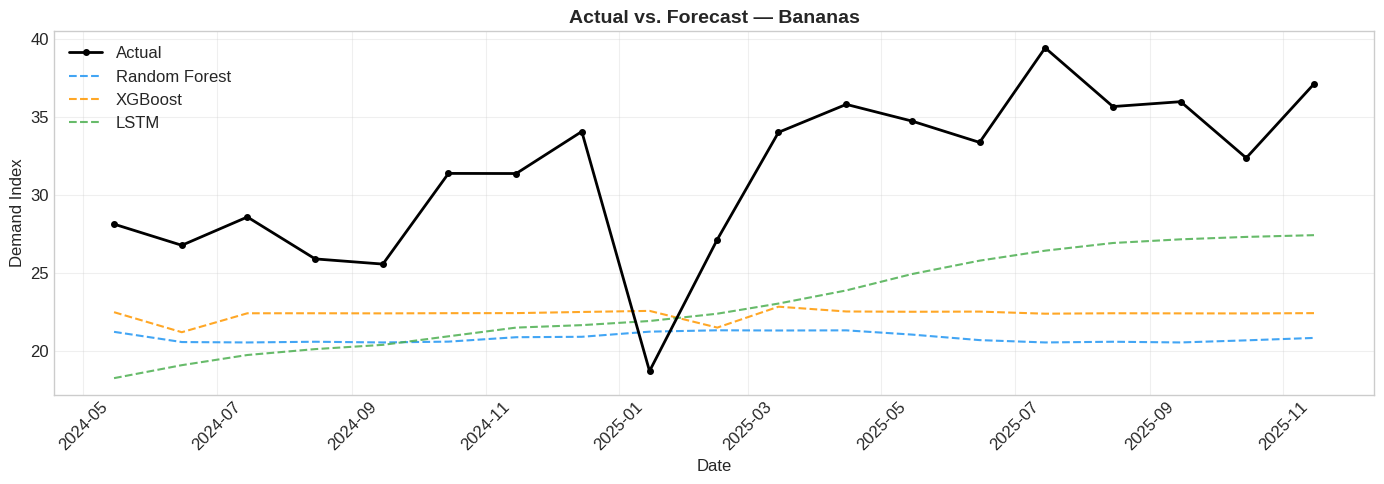

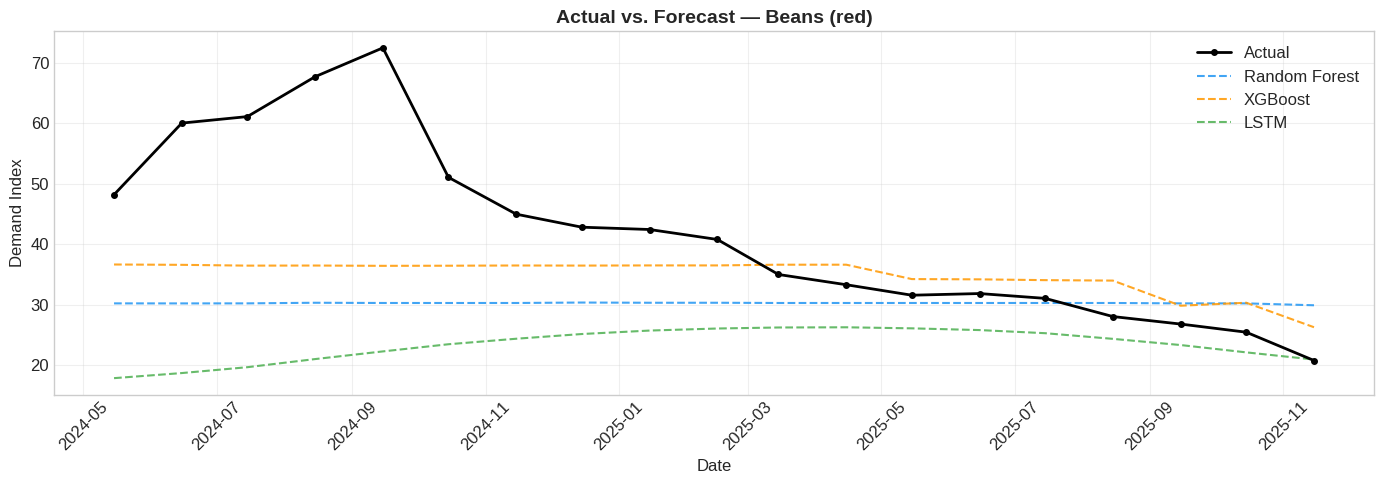

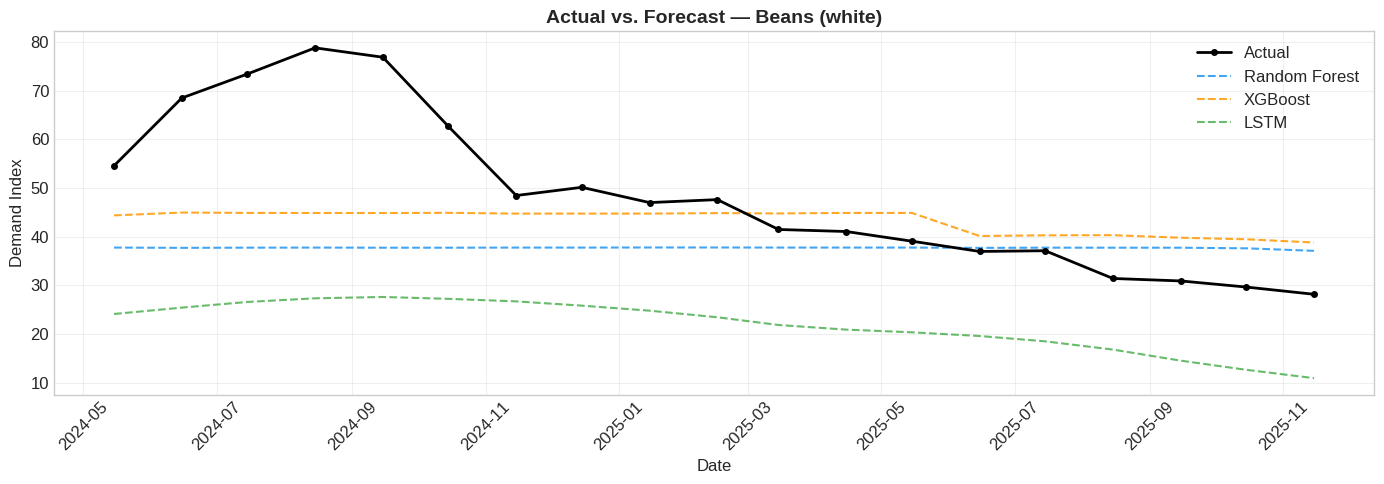

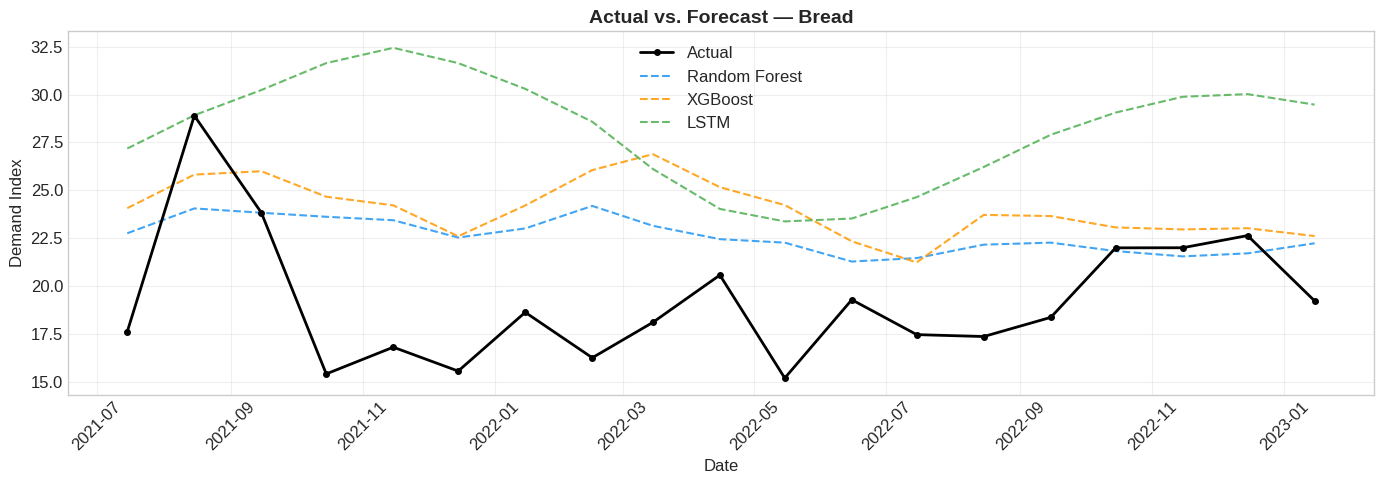

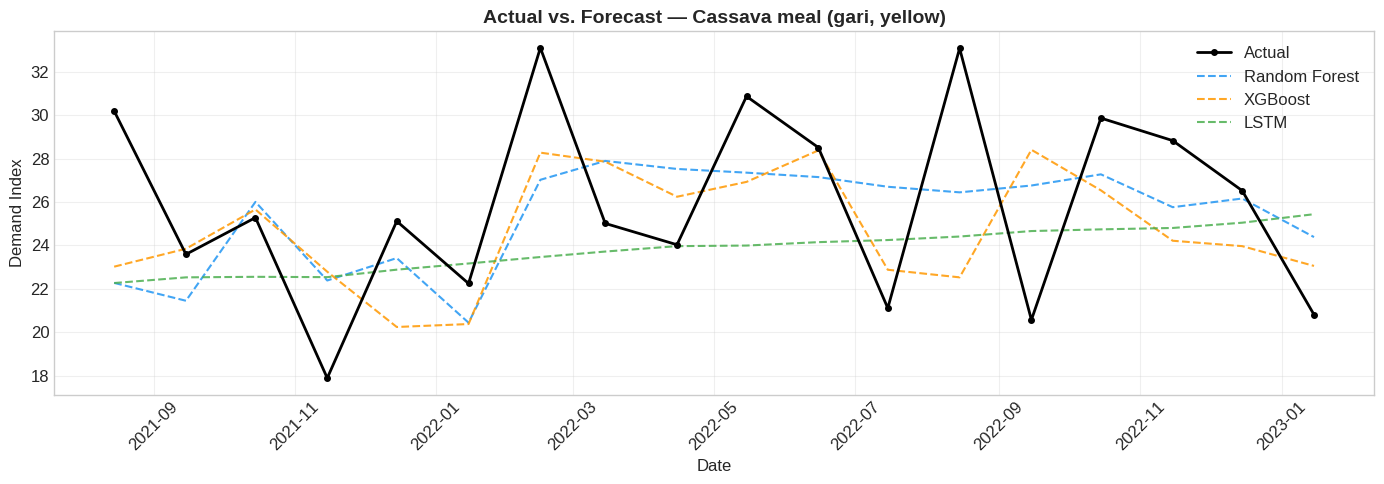

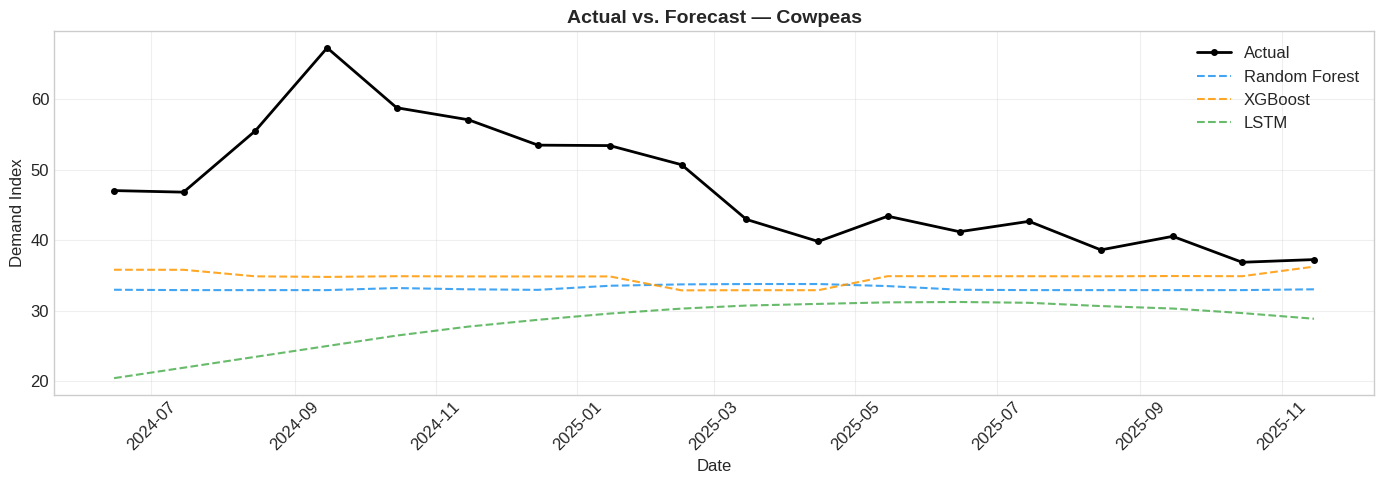

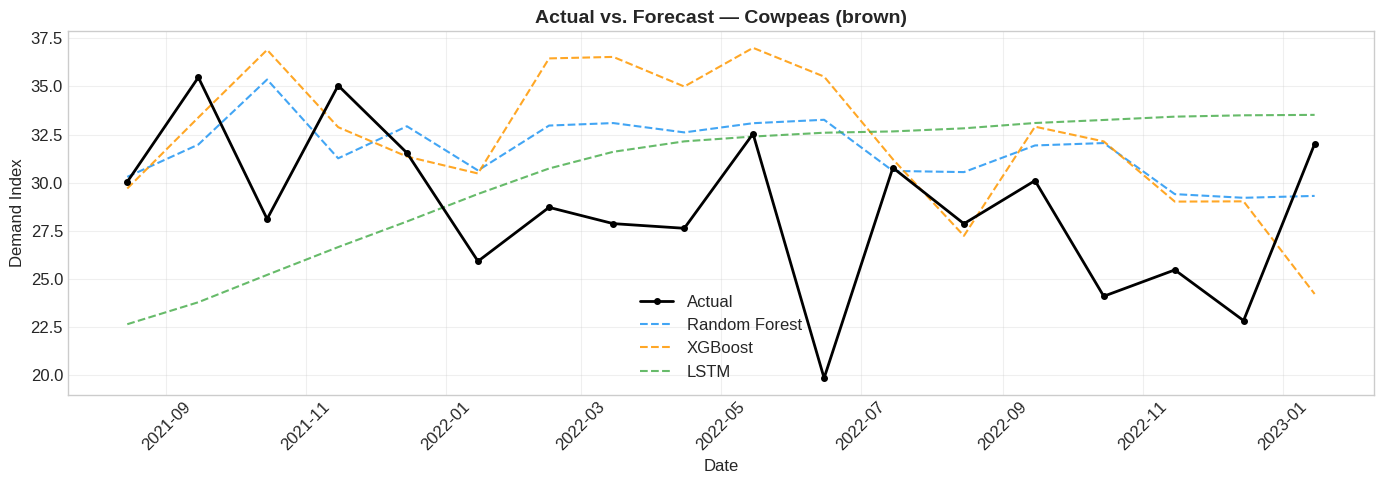

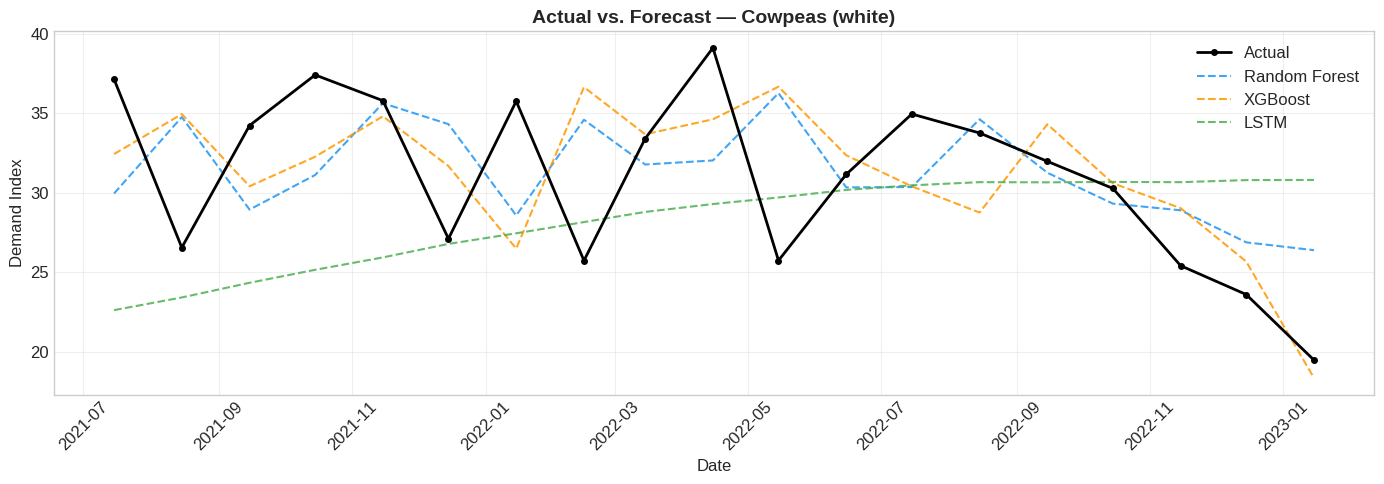

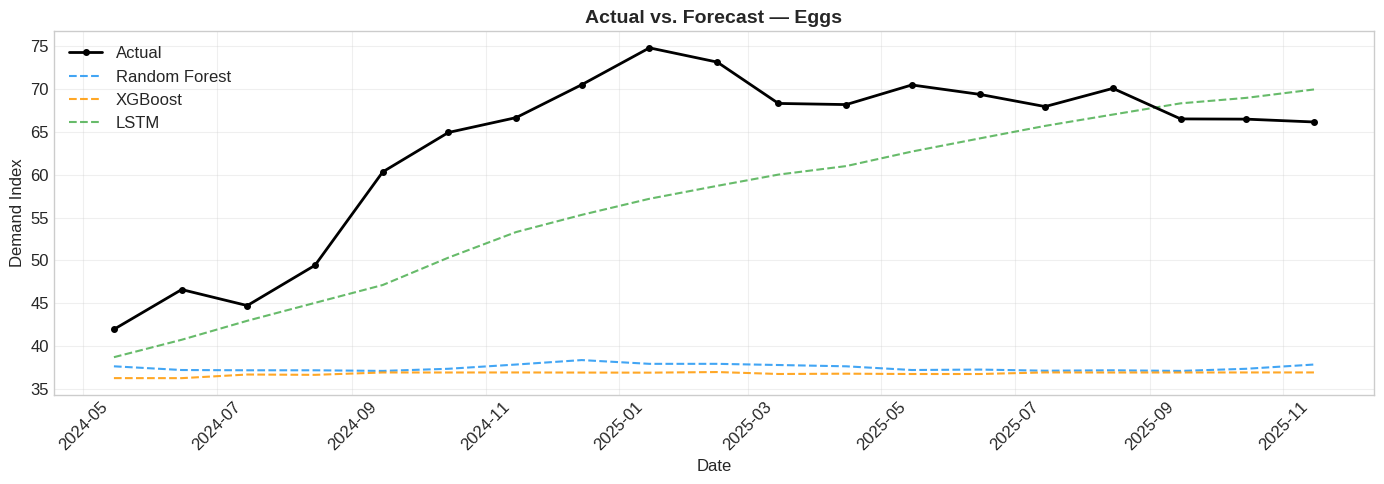

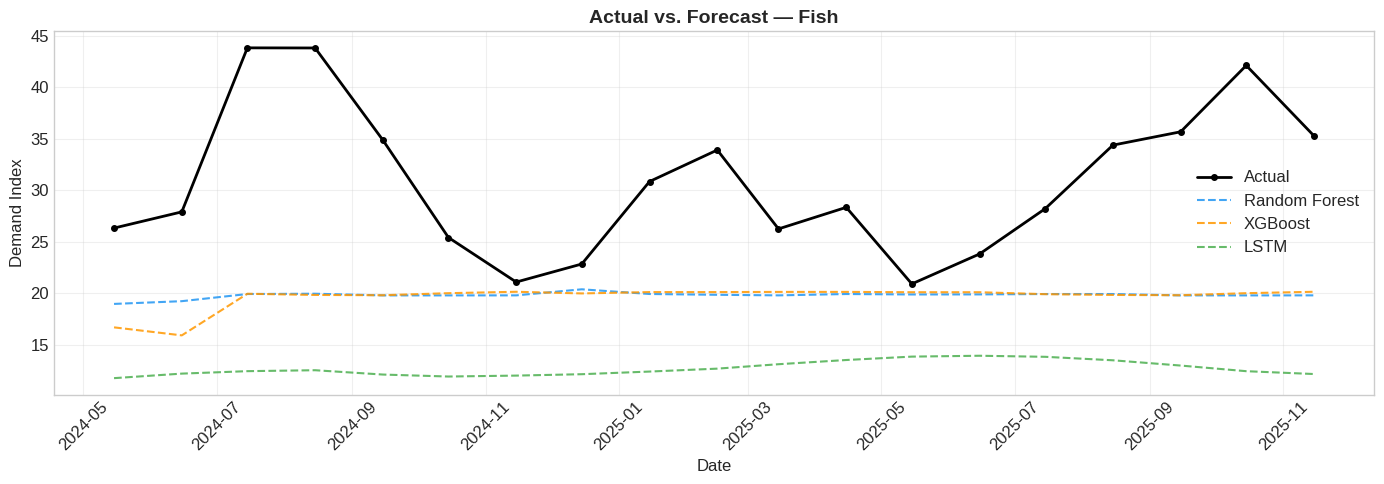

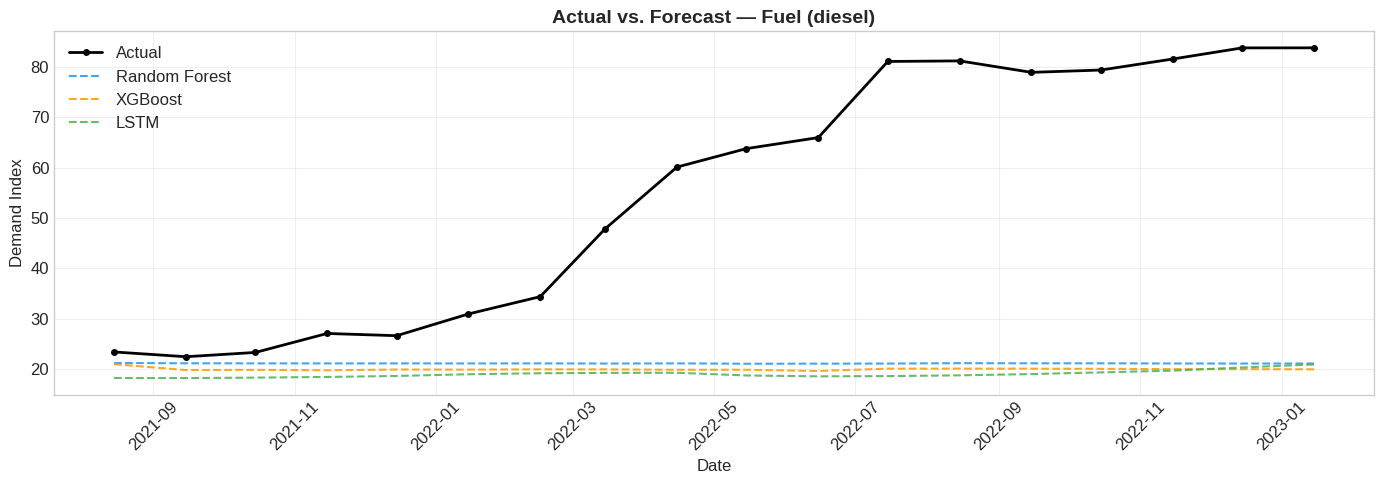

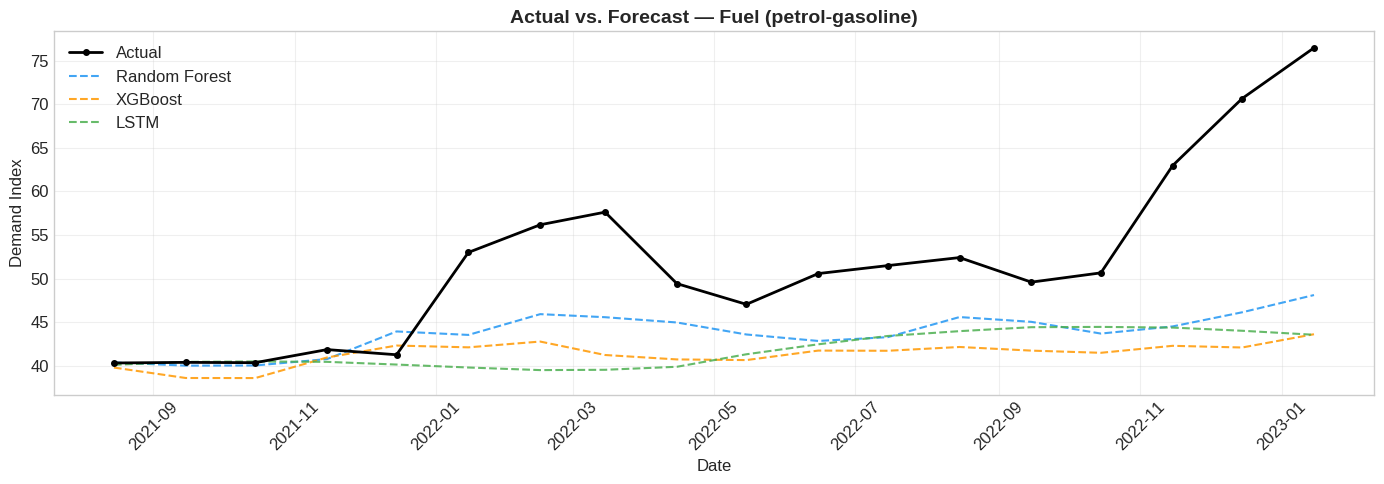

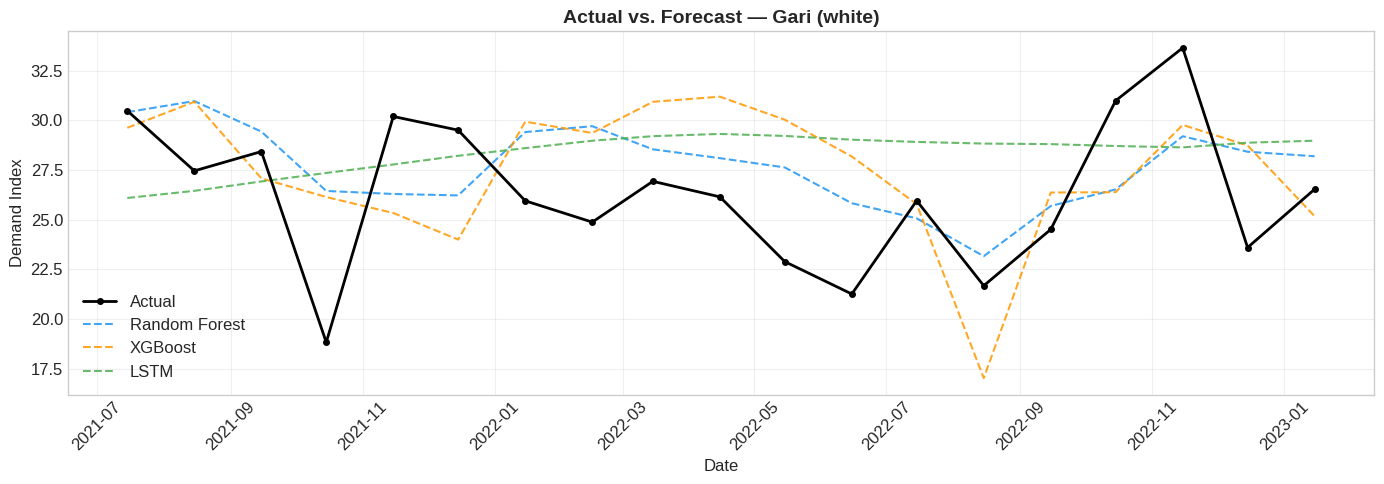

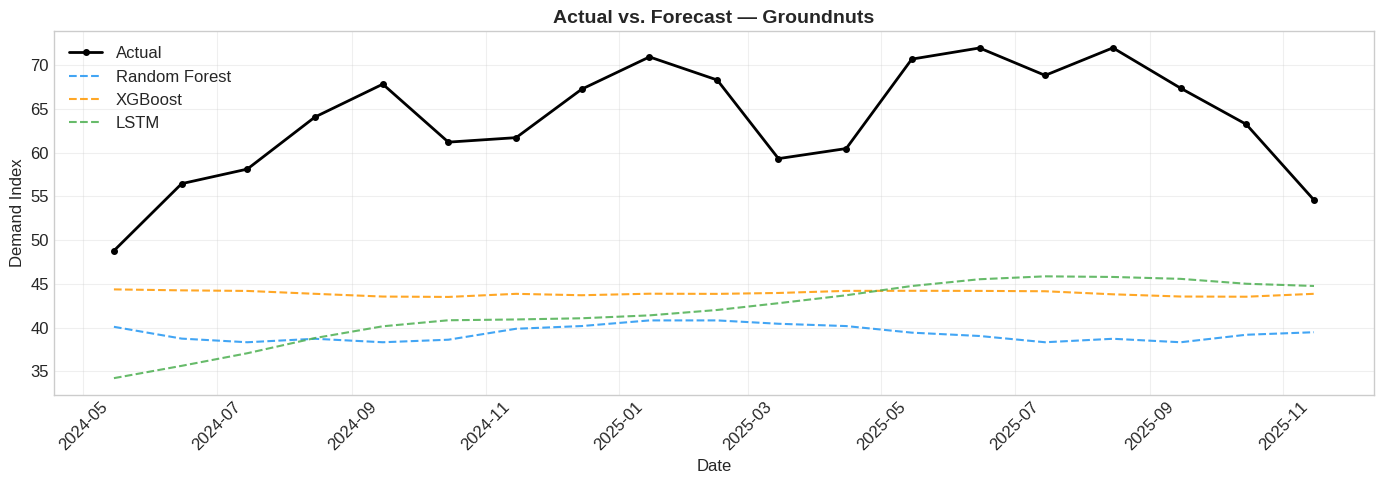

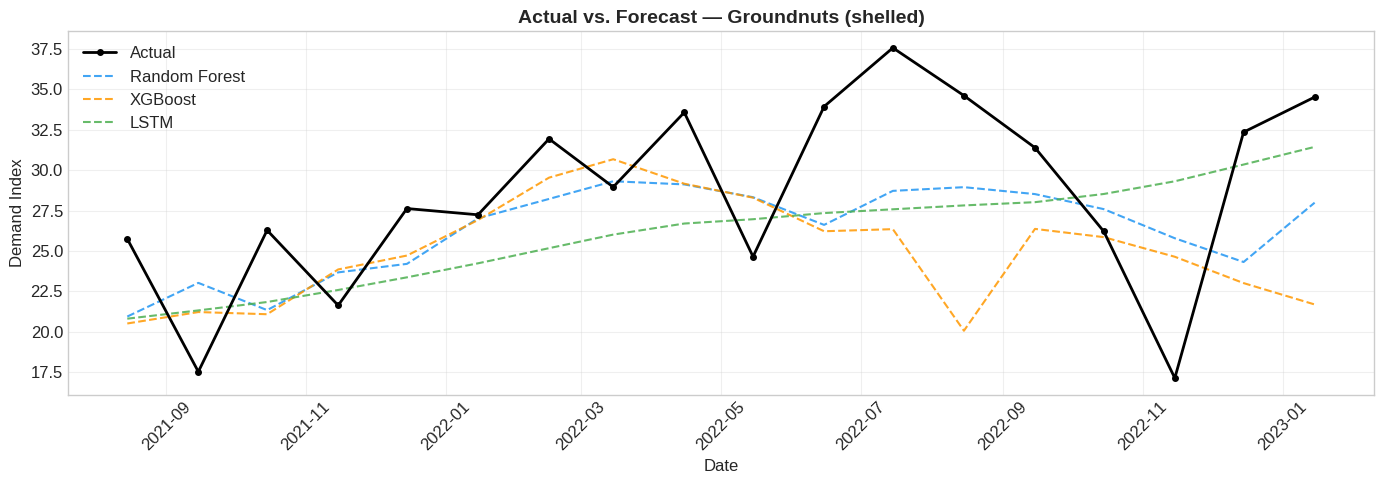

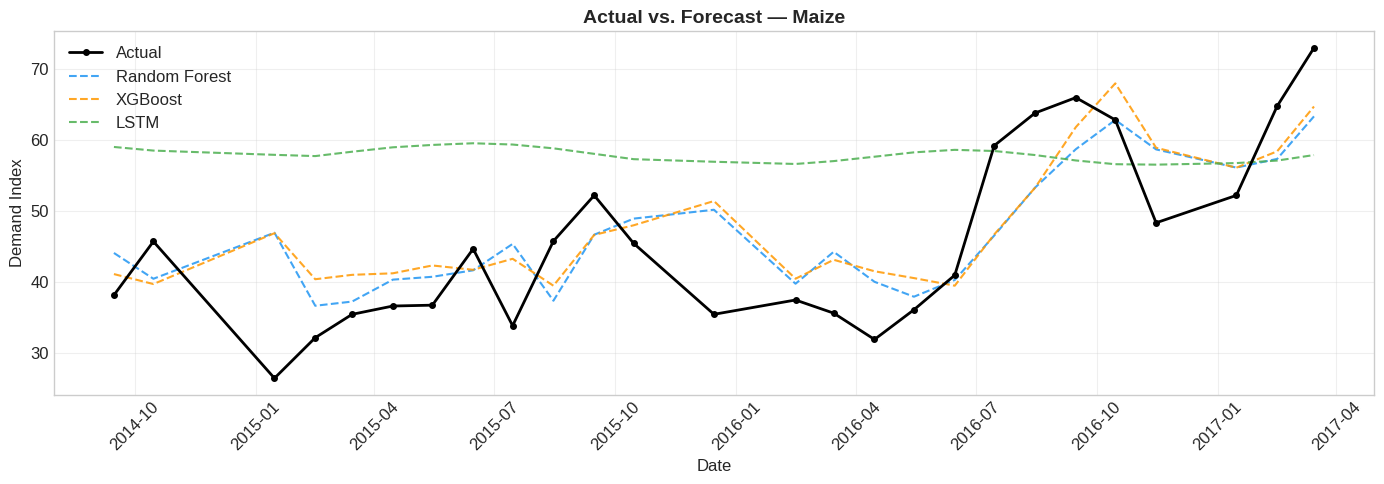

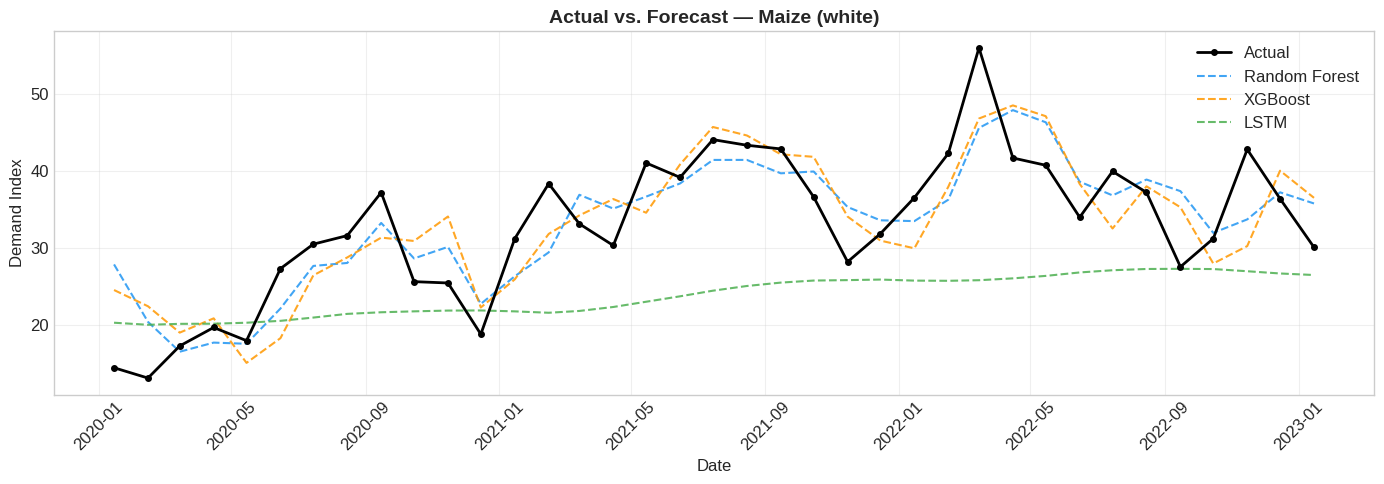

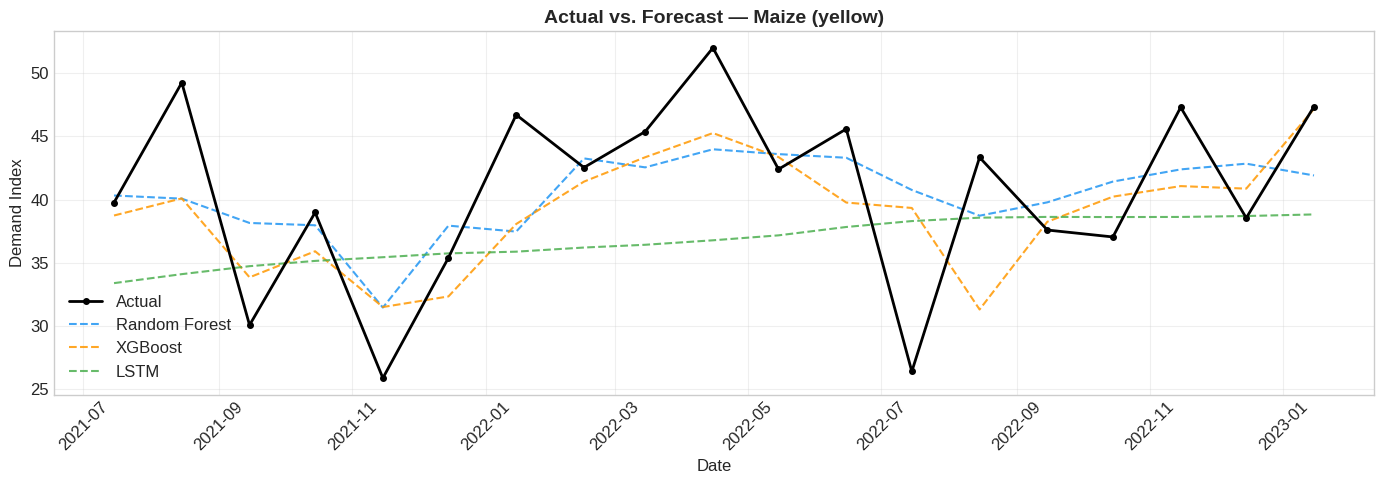

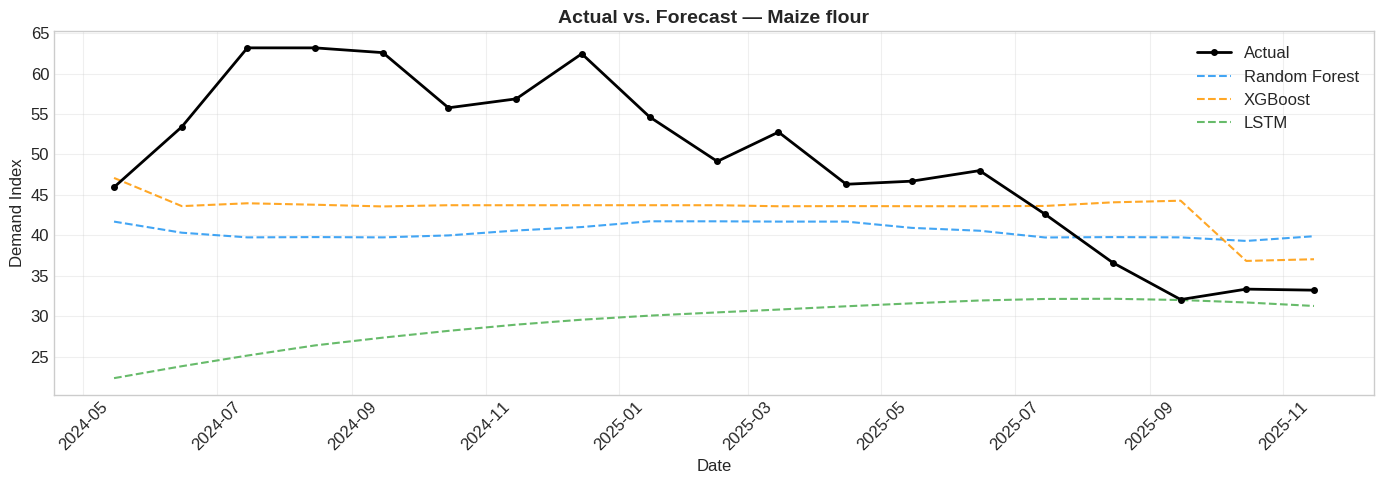

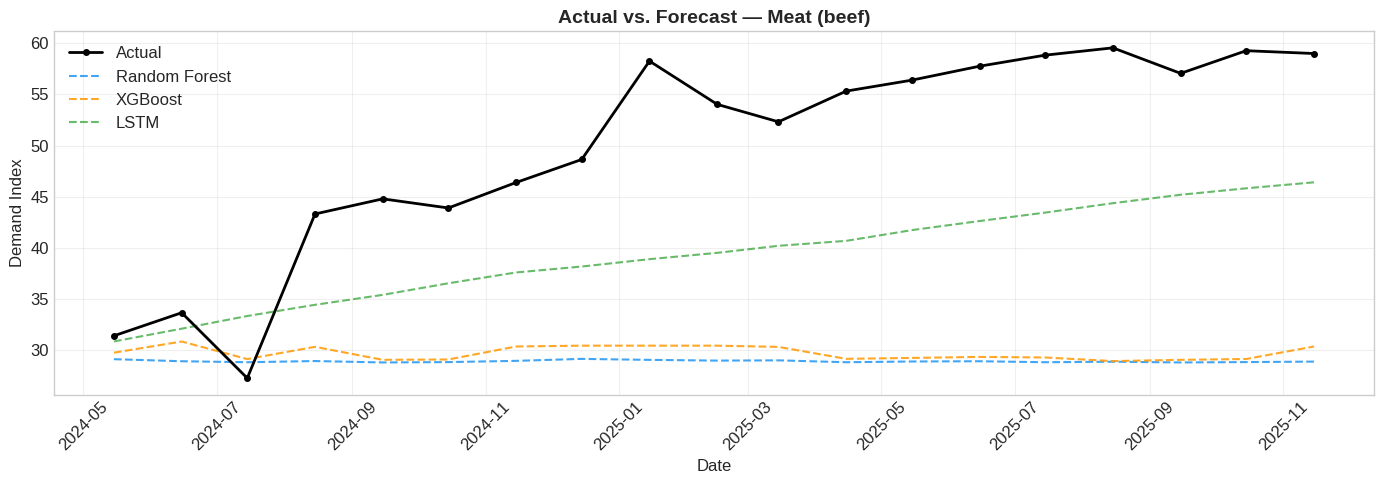

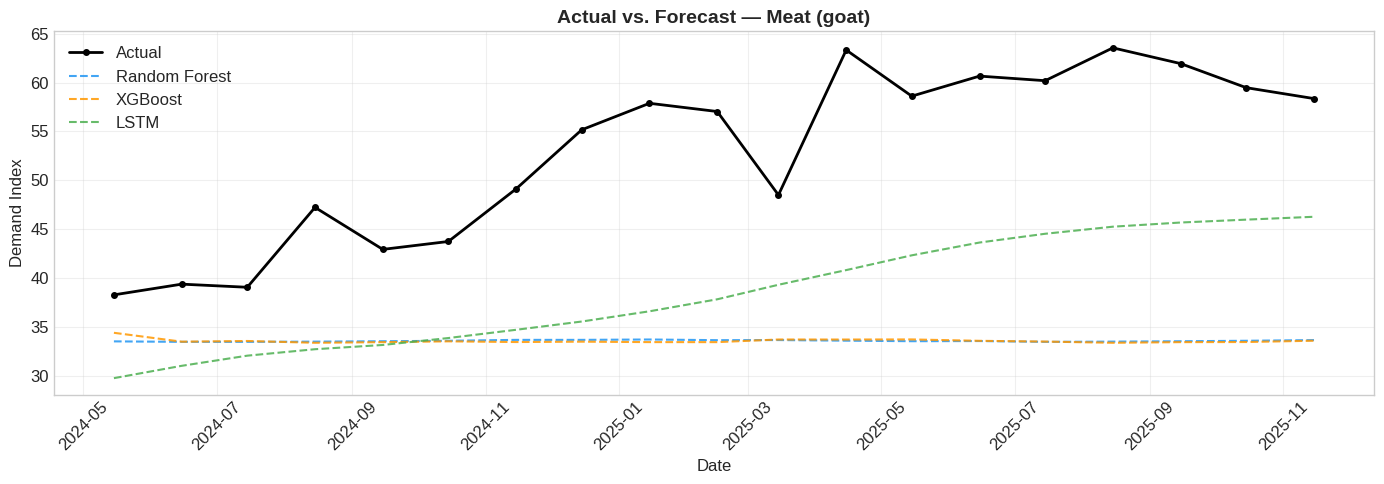

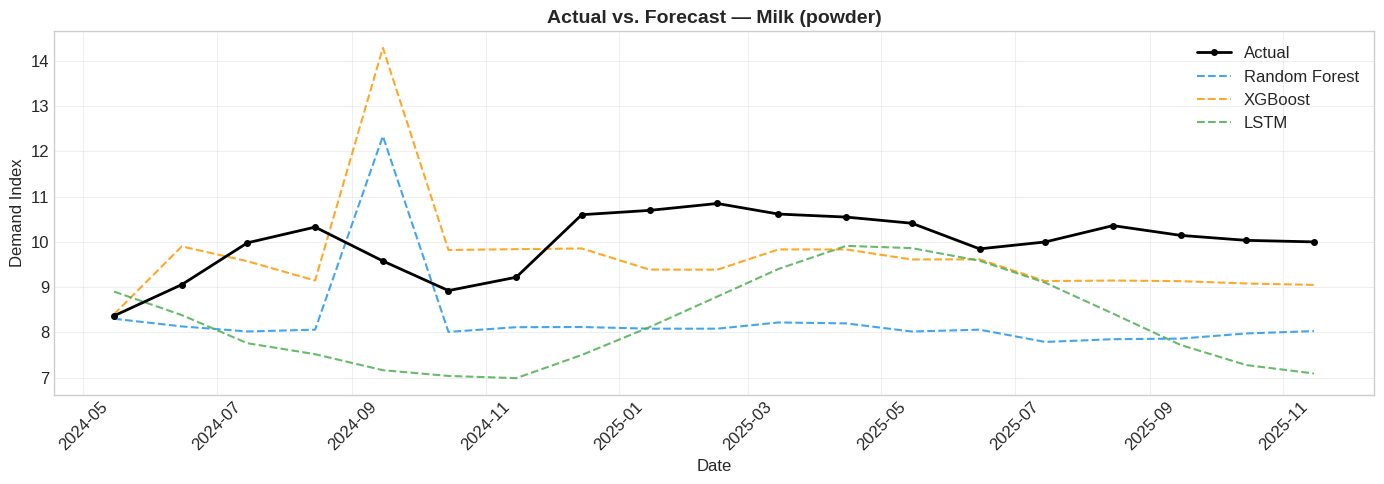

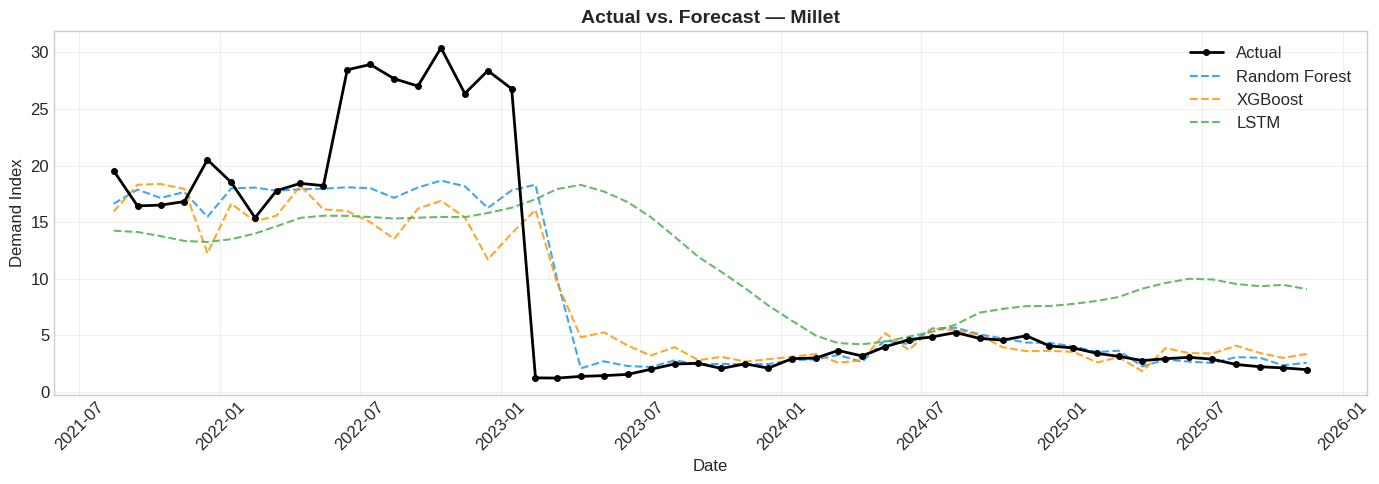

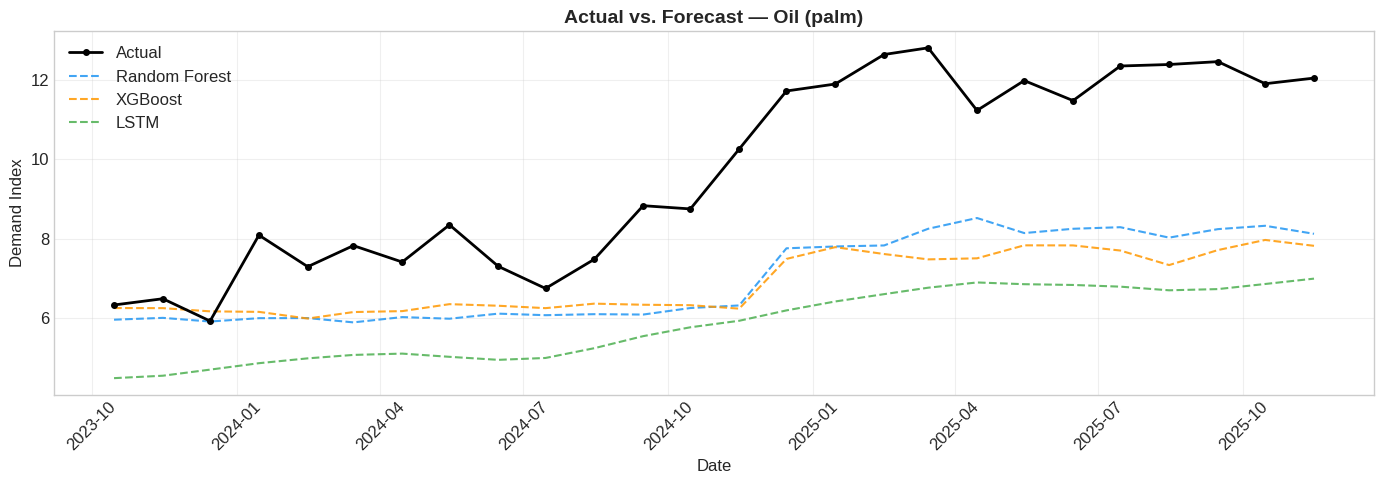

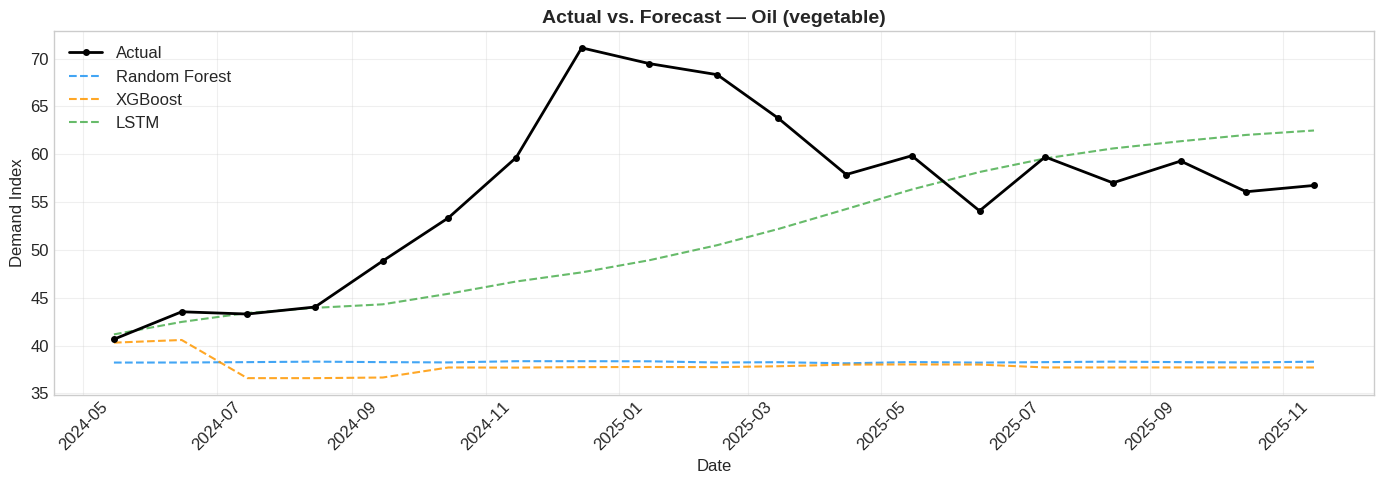

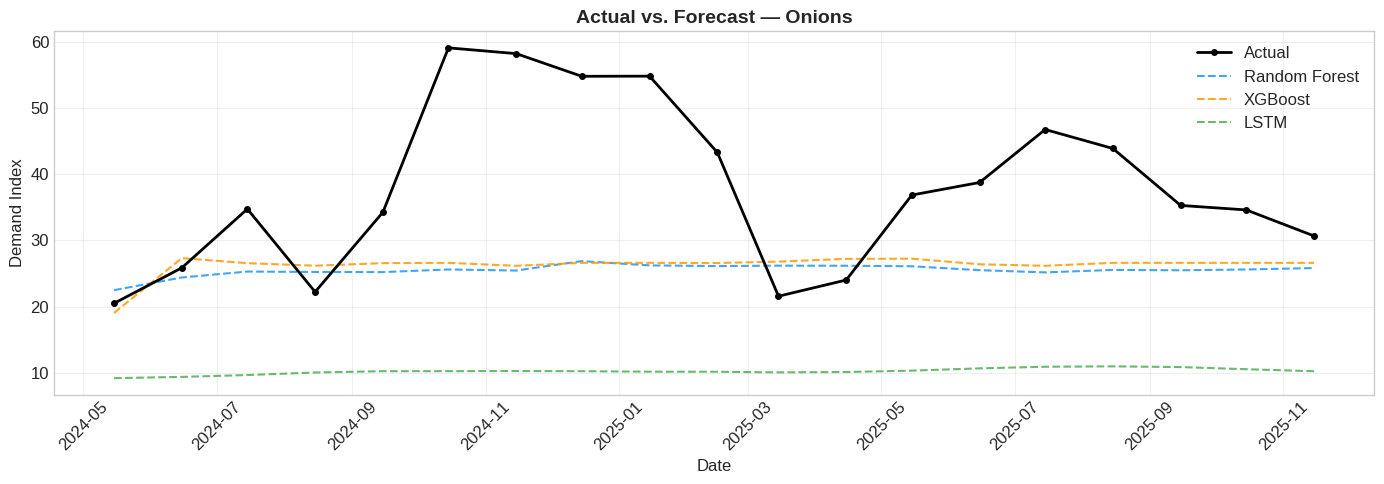

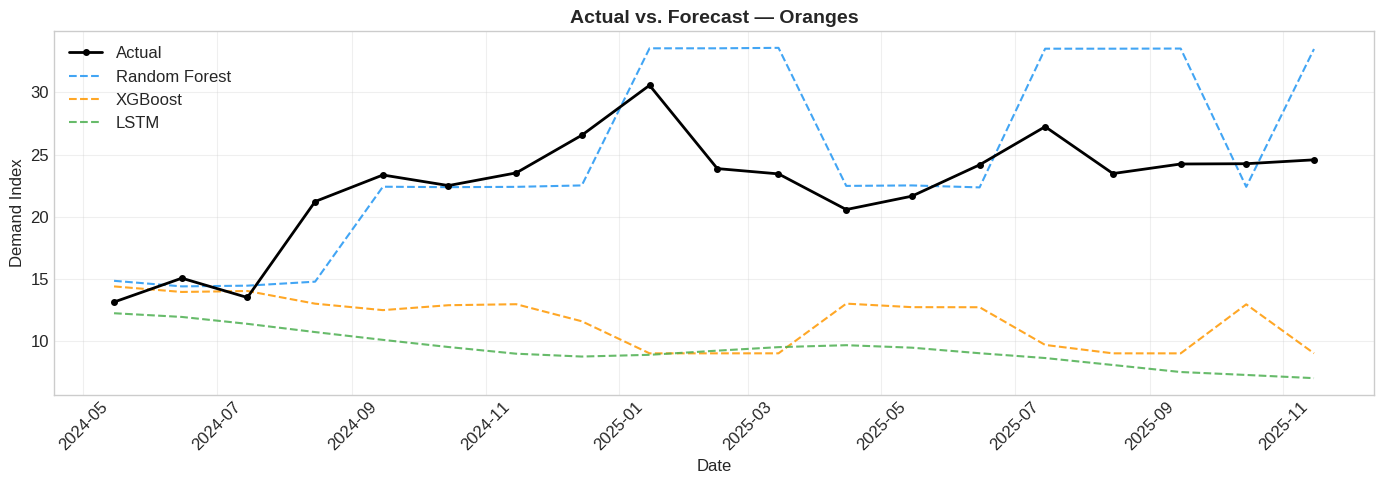

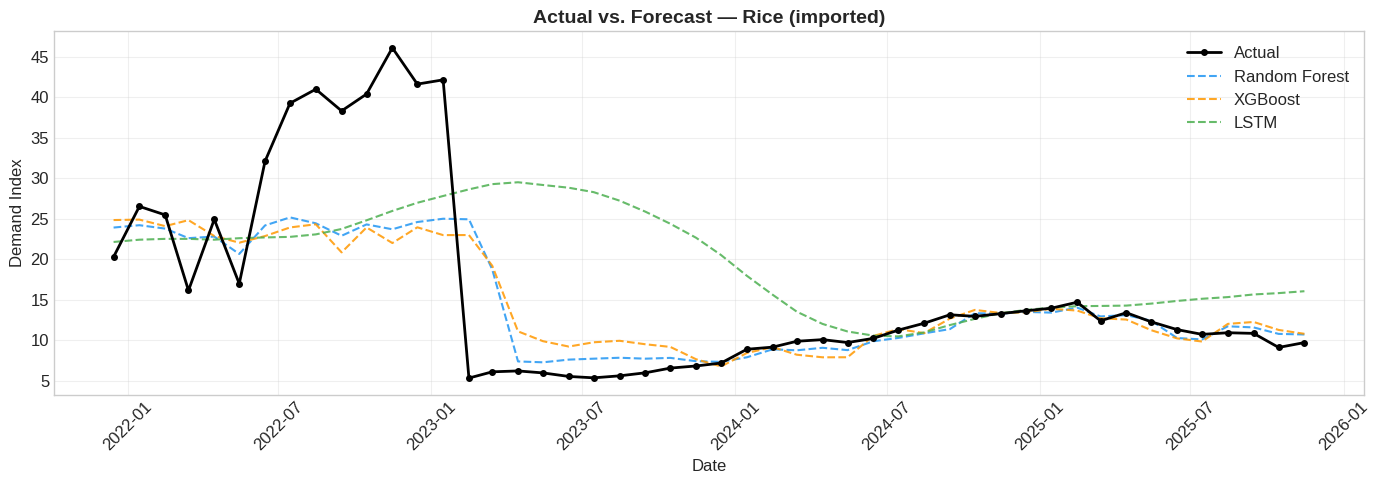

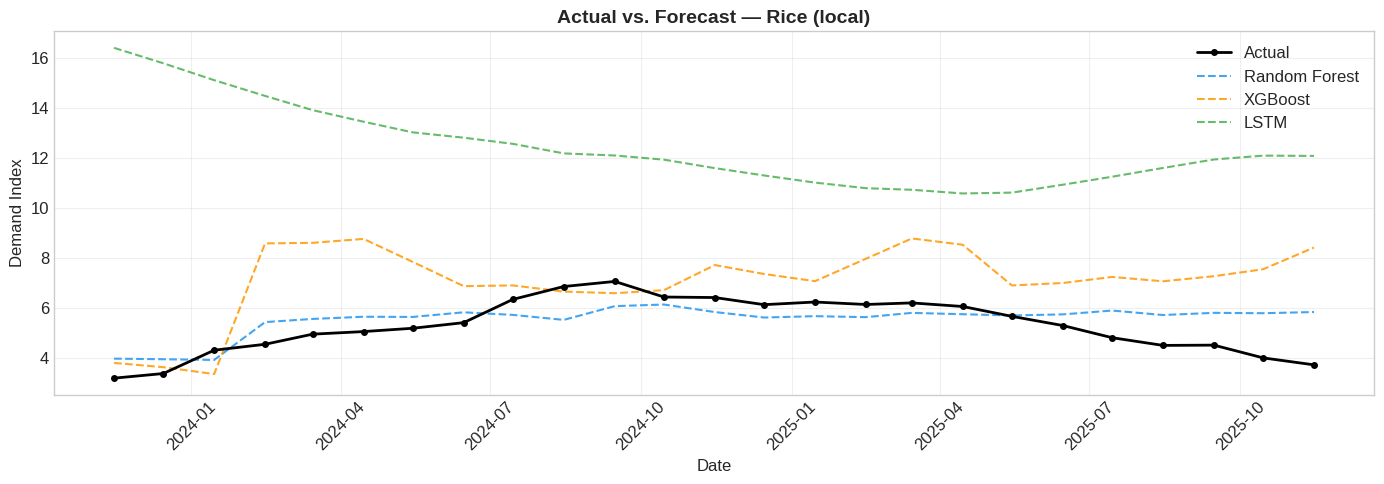

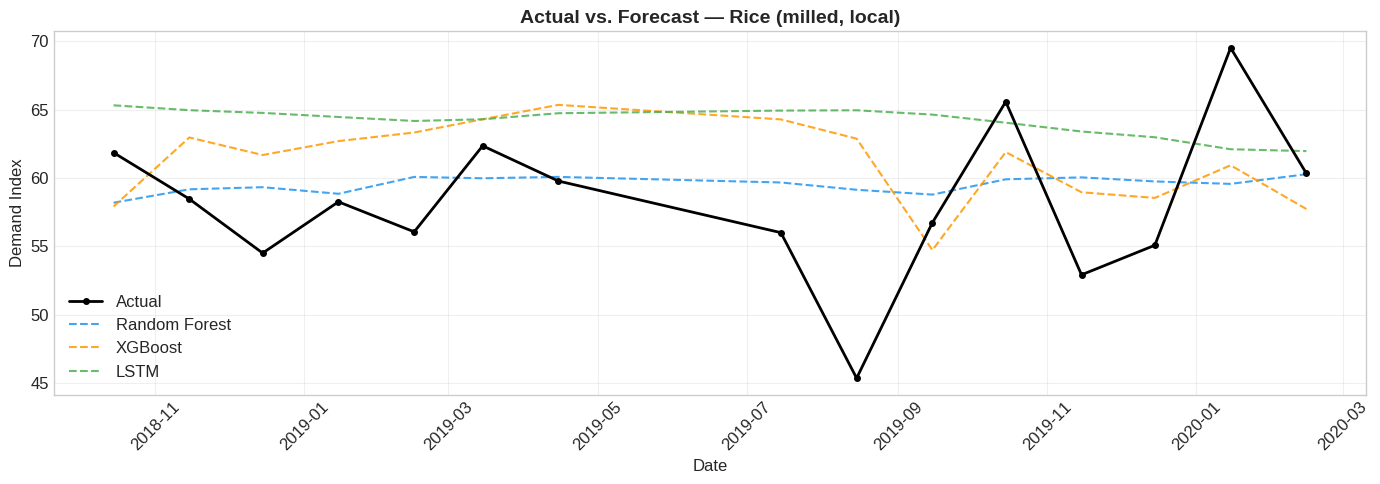

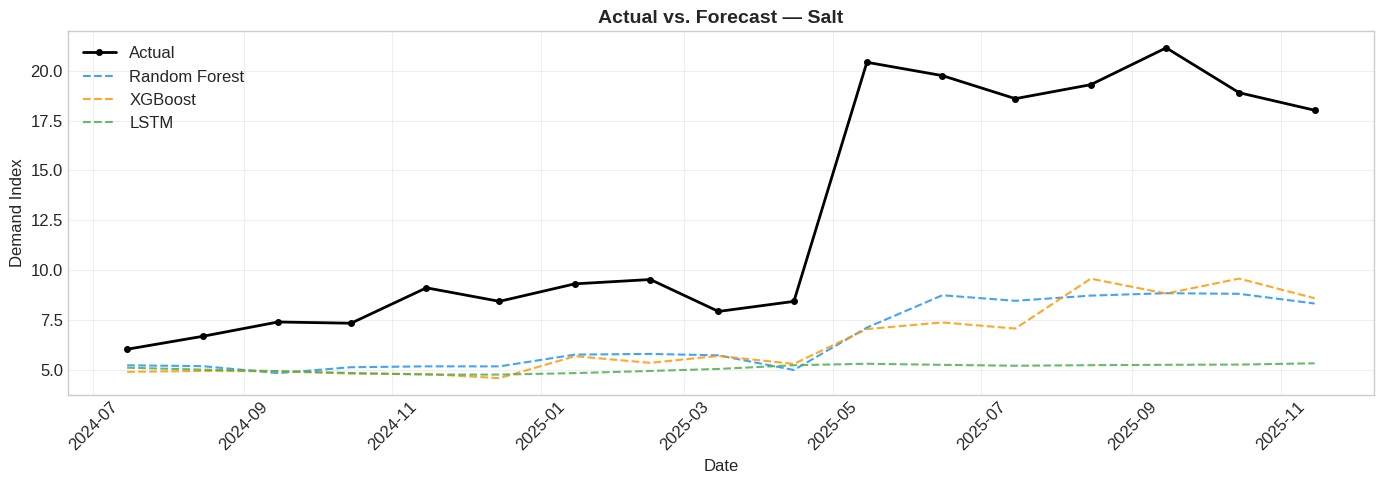

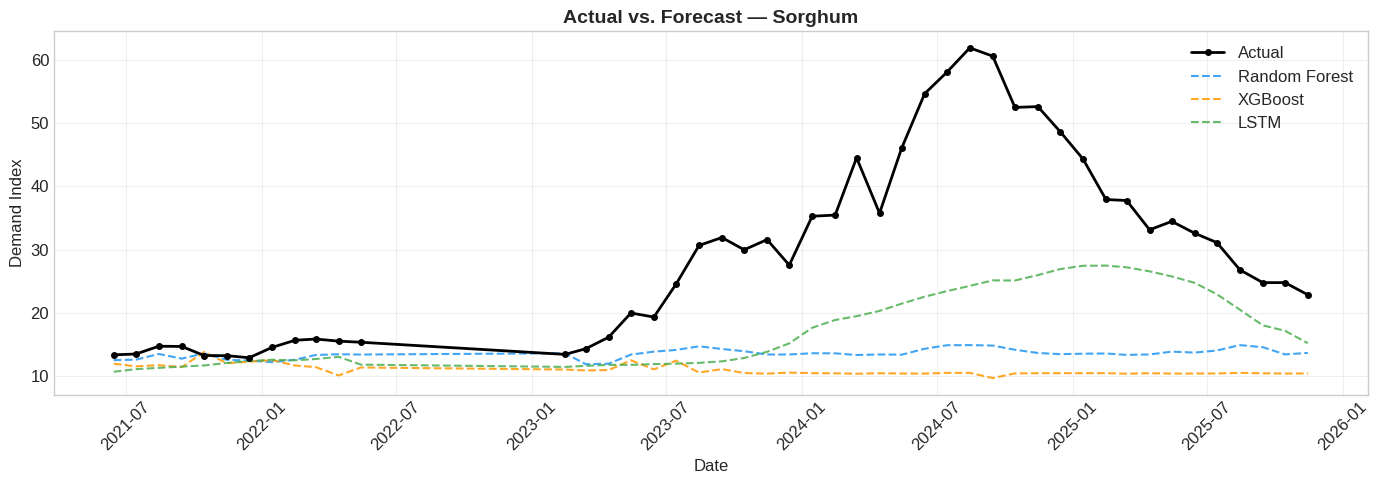

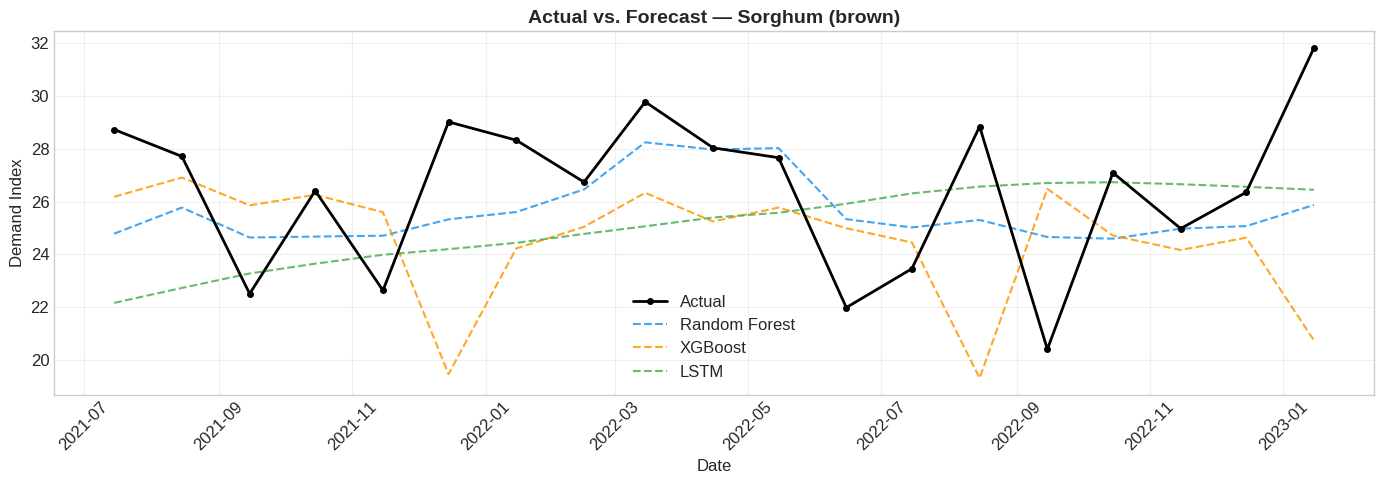

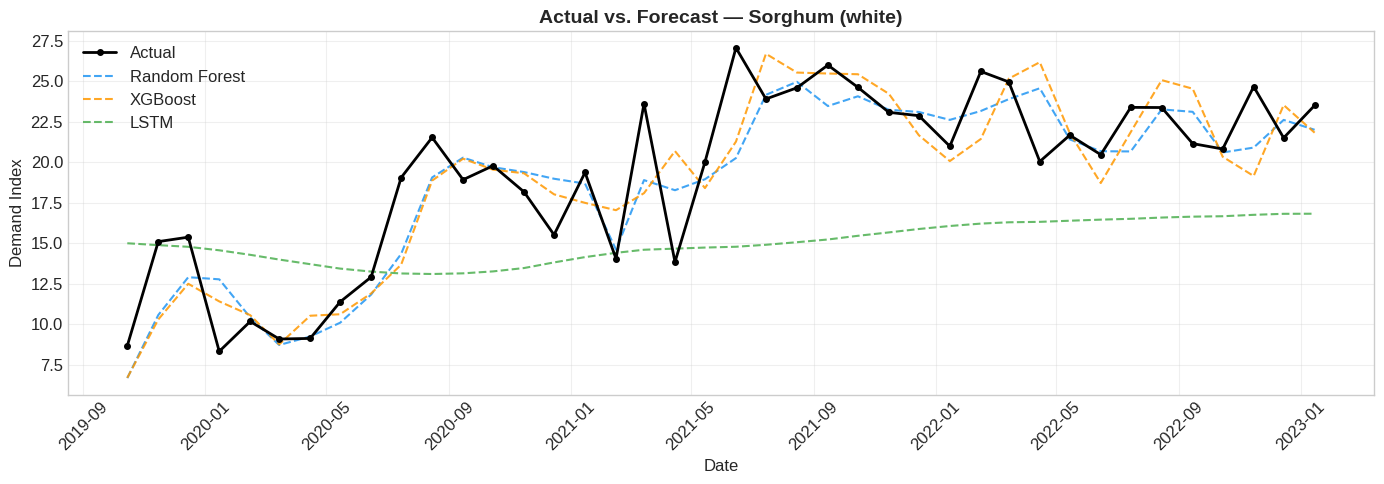

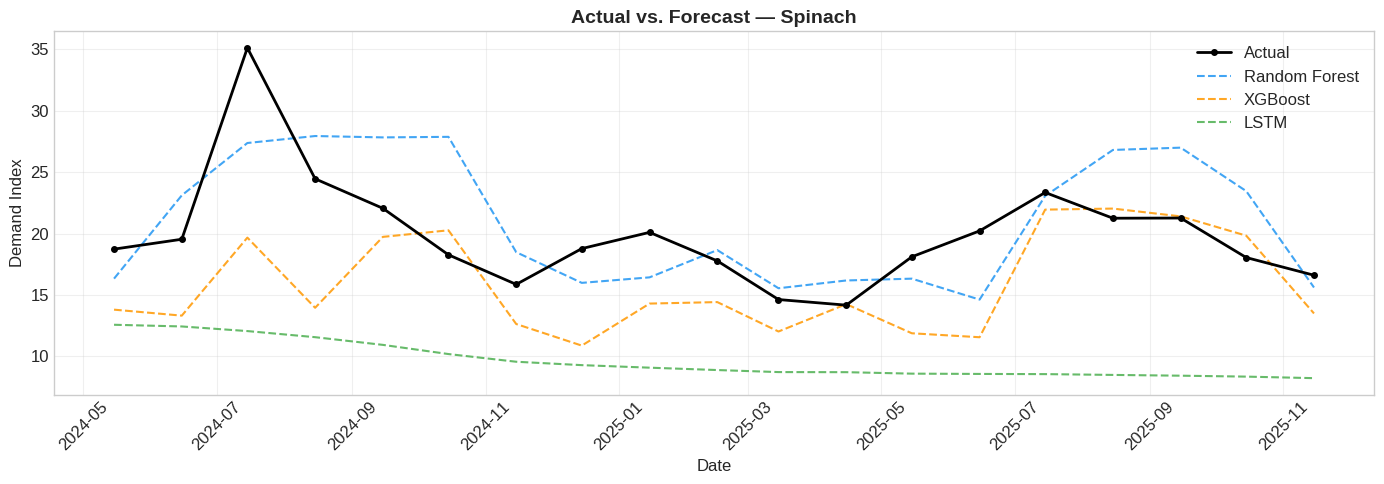

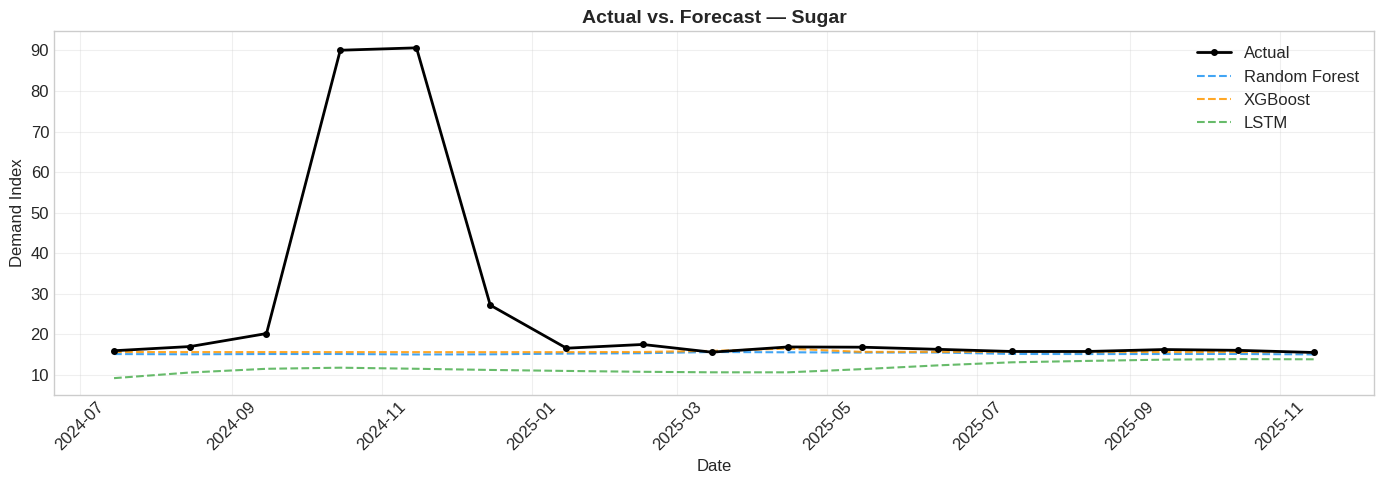

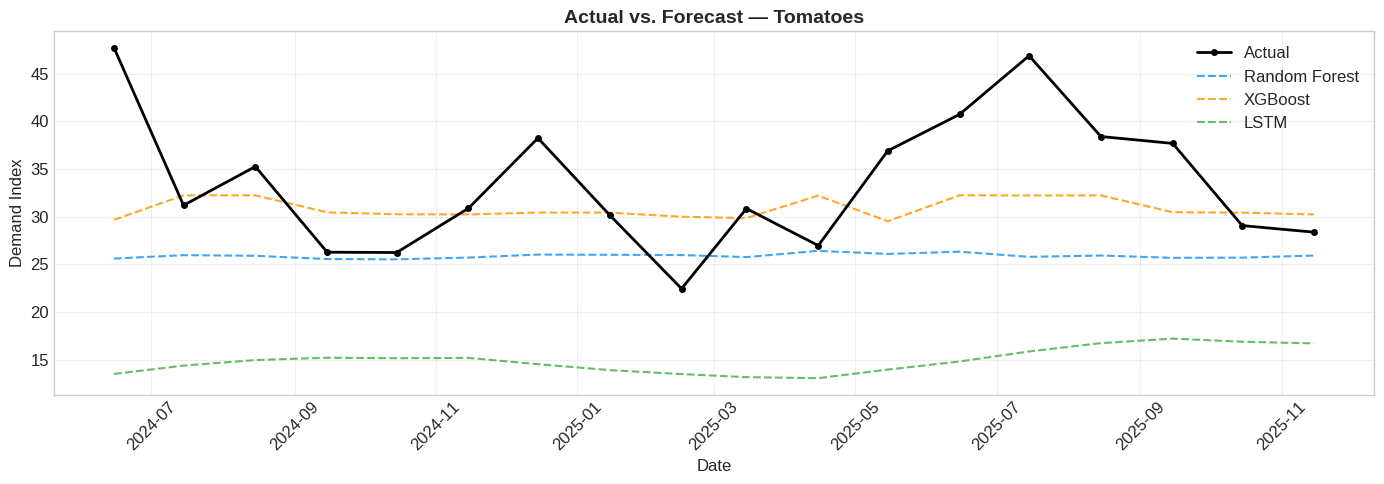

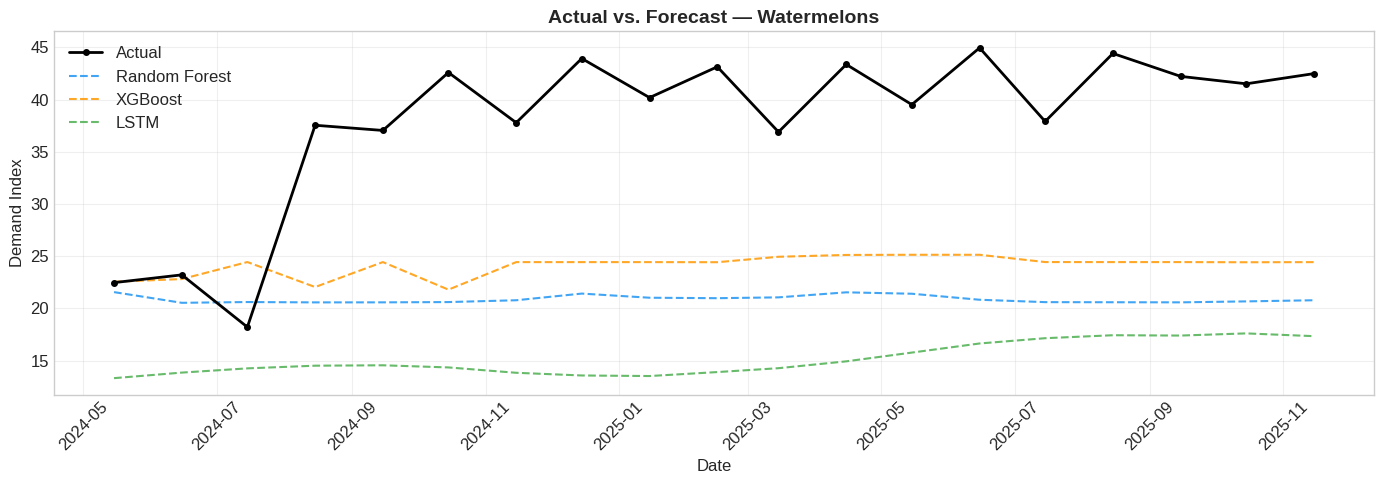

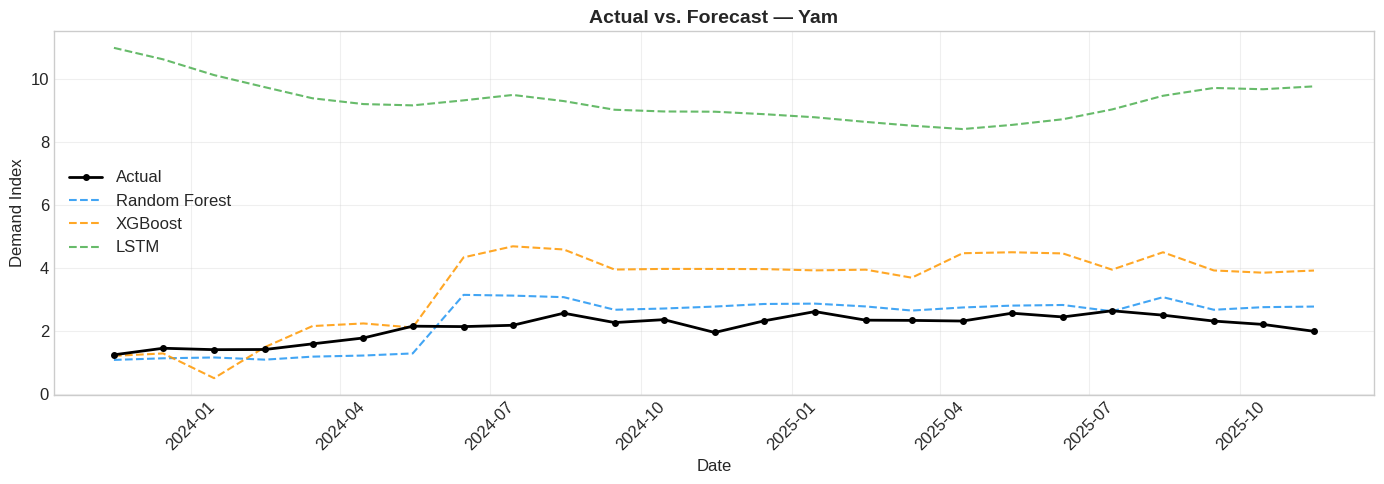

In [ ]:
# ============================================================
# Cell 12: Actual vs. Forecast Visualisations
# ============================================================

def plot_actual_vs_forecast(commodity, output):
    """Plot actual vs predicted values for all three models."""
    fig, ax = plt.subplots(figsize=(14, 5))

    test_dates  = pd.to_datetime(output['test_dates'])
    y_test      = output['y_test']
    predictions = output['predictions']

    # Actual values
    ax.plot(test_dates, y_test, 'k-o', label='Actual',
            linewidth=2, markersize=4, zorder=5)

    # Model predictions
    colors = {'Random Forest': '#2196F3', 'XGBoost': '#FF9800', 'LSTM': '#4CAF50'}
    for model_name, pred in predictions.items():
        if not np.all(np.isnan(pred)):
            ax.plot(test_dates, pred, '--', label=model_name,
                    color=colors.get(model_name, 'gray'),
                    linewidth=1.5, alpha=0.85)

    ax.set_title(f'Actual vs. Forecast \u2014 {commodity}',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand Index')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Plot for each commodity
for commodity, output in all_crop_outputs.items():
    plot_actual_vs_forecast(commodity, output)

### 5.2 Performance Comparison Table

RMSE COMPARISON (lower is better)
Model                        Random Forest  XGBoost     LSTM
Commodity                                                   
Bananas                            11.6587  10.2447   9.0182
Beans (red)                        18.6017  14.6652  24.4157
Beans (white)                      19.2449  15.3209  29.2742
Bread                               4.8113   5.8906   9.8493
Cassava meal (gari, yellow)         4.1394   4.5612   4.8733
Cowpeas                            16.5661  15.2524  21.8251
Cowpeas (brown)                     5.2192   6.4343   6.6456
Cowpeas (white)                     5.7523   5.4935   7.3192
Eggs                               27.7921  28.4335   9.2730
Fish                               13.0850  13.2275  19.5085
Fuel (diesel)                      42.0031  42.9388  43.4809
Fuel (petrol-gasoline)             11.4787  13.8288  13.5725
Gari (white)                        3.6498   4.5239   4.5036
Groundnuts                         25.3494  20.9433

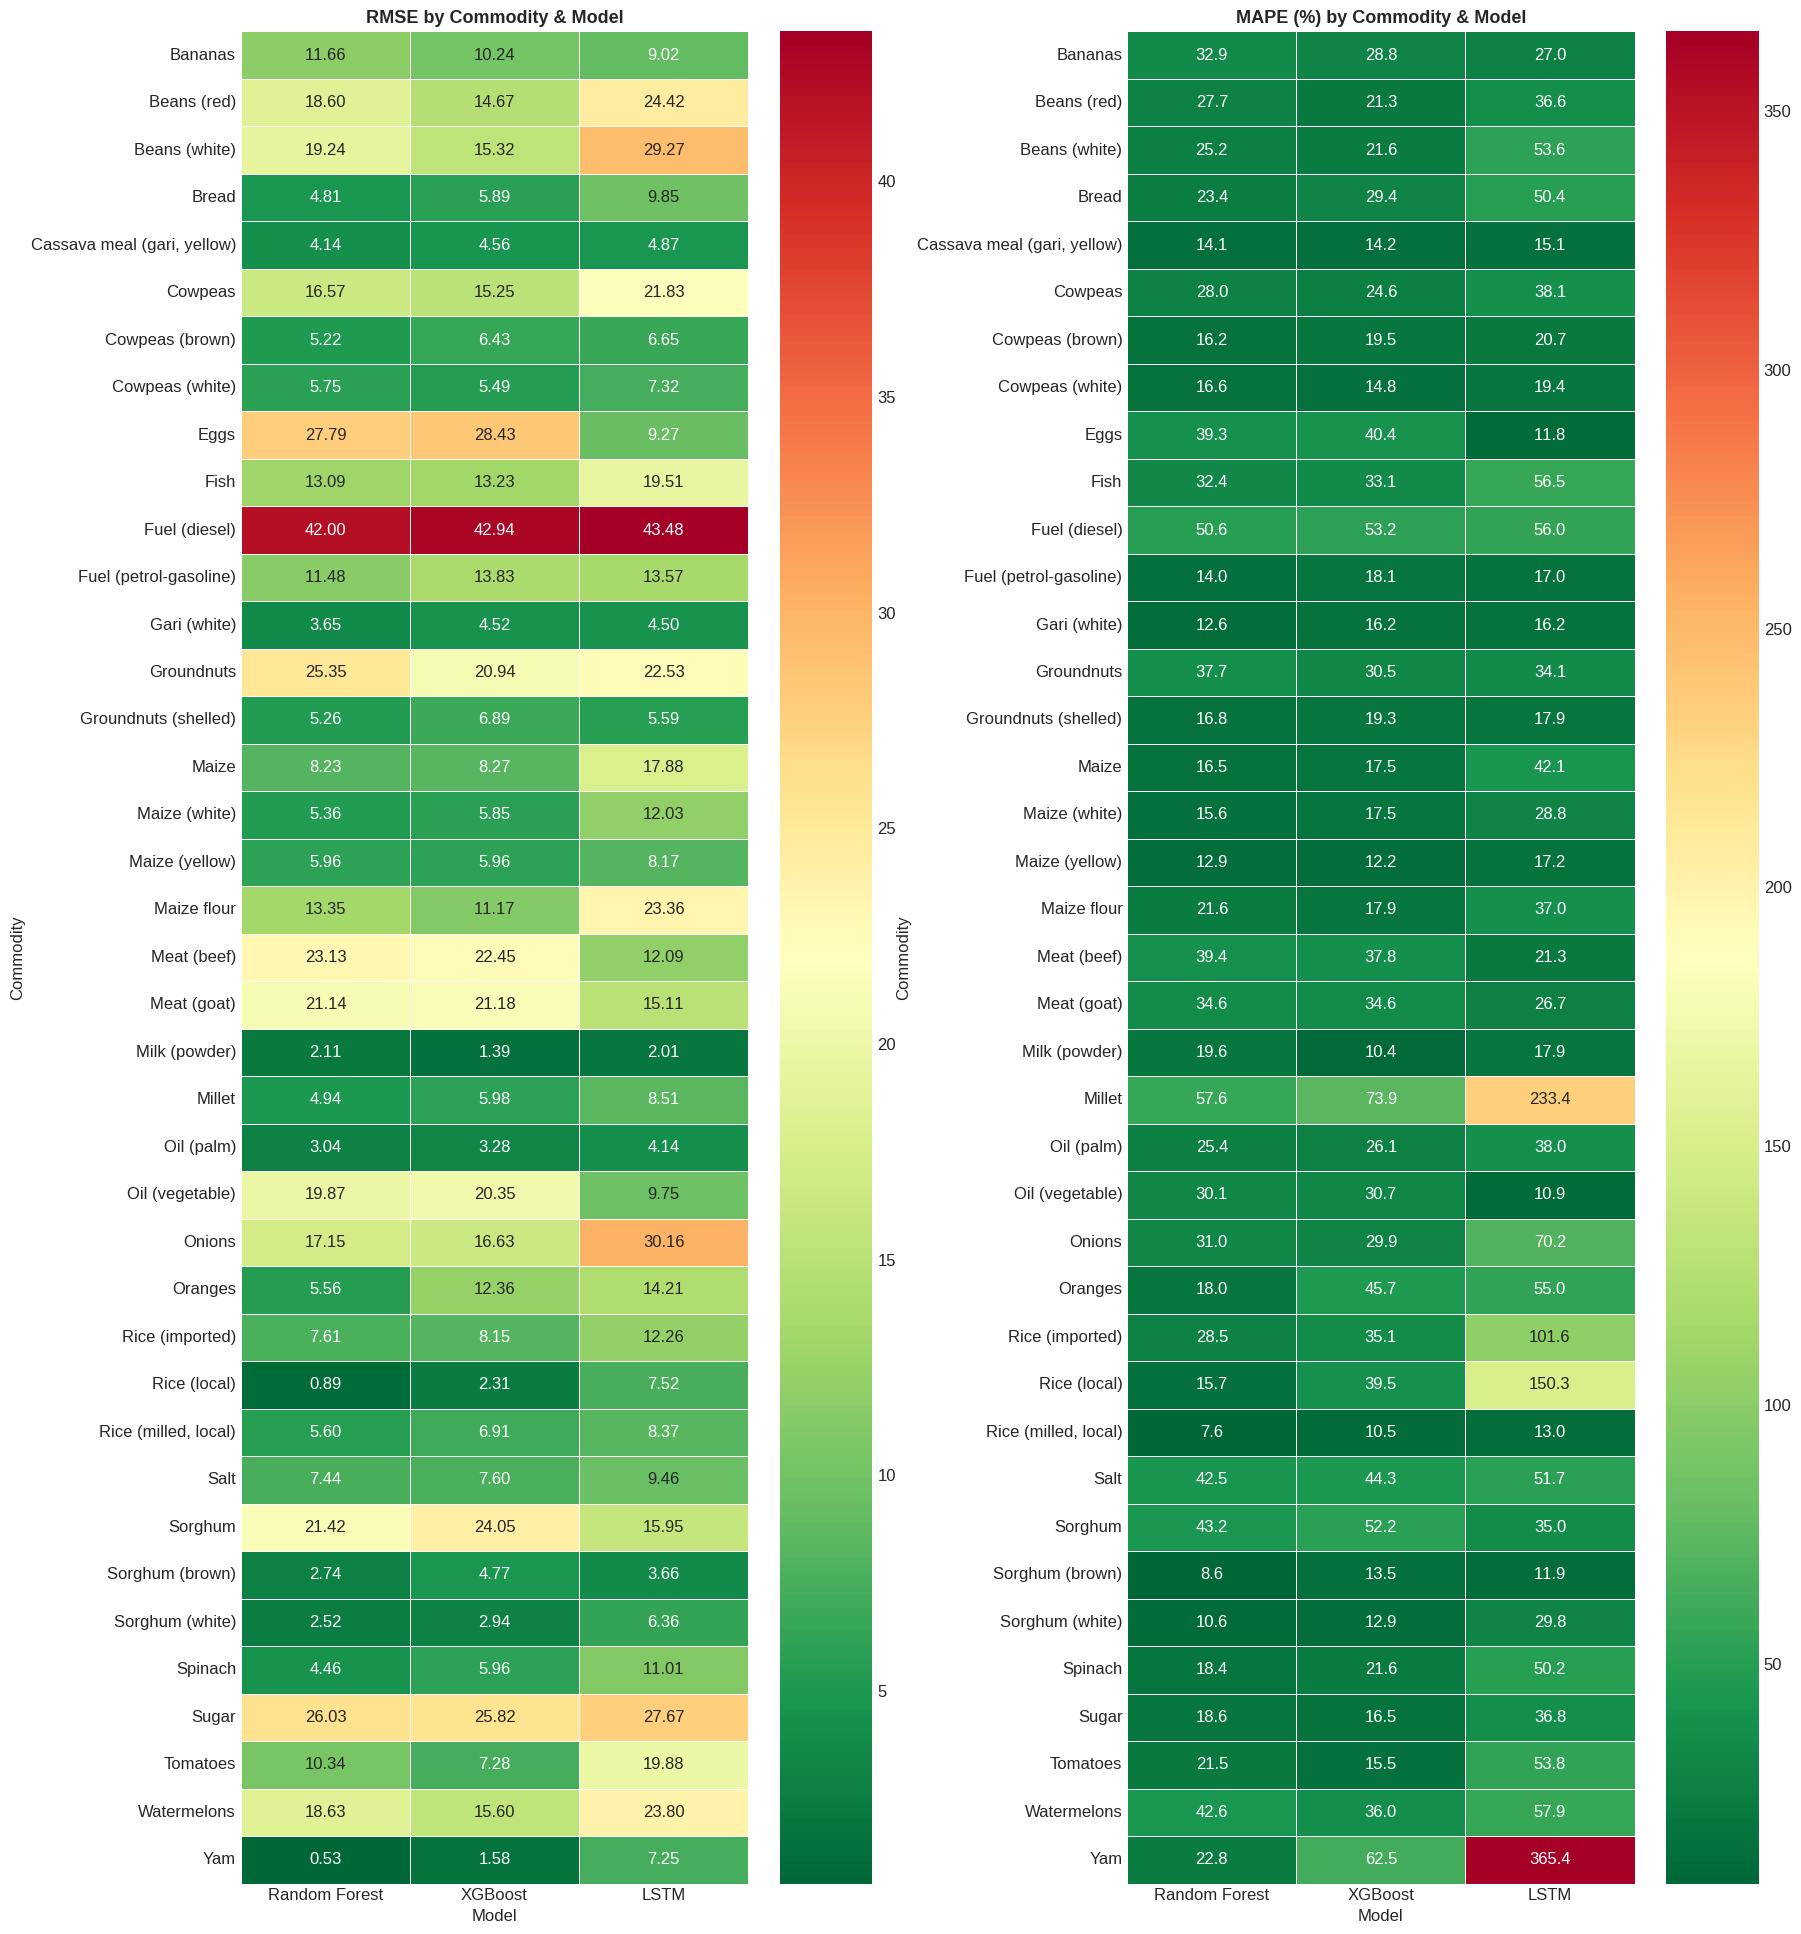

In [ ]:
# ============================================================
# Cell 13: Performance Comparison Table & Heatmaps
# ============================================================

# Build comparison DataFrame
rows = []
for commodity, models in all_results.items():
    for model_name, metrics in models.items():
        rows.append({
            'Commodity': commodity,
            'Model': model_name,
            'RMSE': metrics['RMSE'],
            'MAPE (%)': metrics['MAPE']
        })

results_df = pd.DataFrame(rows)

# Pivot tables
rmse_pivot = results_df.pivot(index='Commodity', columns='Model', values='RMSE')
rmse_pivot = rmse_pivot[['Random Forest', 'XGBoost', 'LSTM']]

mape_pivot = results_df.pivot(index='Commodity', columns='Model', values='MAPE (%)')
mape_pivot = mape_pivot[['Random Forest', 'XGBoost', 'LSTM']]

print('=' * 70)
print('RMSE COMPARISON (lower is better)')
print('=' * 70)
print(rmse_pivot.to_string())

print(f"\n{'=' * 70}")
print('MAPE (%) COMPARISON (lower is better)')
print('=' * 70)
print(mape_pivot.to_string())

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, max(6, len(all_results) * 0.5)))

sns.heatmap(rmse_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r',
            ax=axes[0], linewidths=0.5)
axes[0].set_title('RMSE by Commodity & Model', fontsize=13, fontweight='bold')

sns.heatmap(mape_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=axes[1], linewidths=0.5)
axes[1].set_title('MAPE (%) by Commodity & Model', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.3 Champion Model Selection

In [ ]:
# ============================================================
# Cell 14: Champion Model per Commodity
# ============================================================

print('=' * 70)
print('CHAMPION MODEL PER COMMODITY (Lowest RMSE)')
print('=' * 70)

champion_rows = []
for commodity, models in all_results.items():
    best_model = None
    best_rmse  = float('inf')

    for model_name, metrics in models.items():
        if not np.isnan(metrics['RMSE']) and metrics['RMSE'] < best_rmse:
            best_rmse  = metrics['RMSE']
            best_model = model_name

    champion_rows.append({
        'Commodity': commodity,
        'Champion Model': best_model,
        'RMSE': best_rmse,
        'MAPE (%)': models[best_model]['MAPE'] if best_model else np.nan
    })

champion_df = pd.DataFrame(champion_rows)
print(champion_df.to_string(index=False))

# Summary: which model wins most often?
print(f"\n{'─' * 70}")
print('MODEL WIN COUNT:')
print(f"{'─' * 70}")
win_counts = champion_df['Champion Model'].value_counts()
for model, count in win_counts.items():
    pct = count / len(champion_df) * 100
    print(f'  {model}: {count} crops ({pct:.0f}%)')

overall_best = win_counts.index[0]
print(f'\nOverall Recommended Model: {overall_best}')
print(f'  Champion for {win_counts.iloc[0]}/{len(champion_df)} commodities')

CHAMPION MODEL PER COMMODITY (Lowest RMSE)
                  Commodity Champion Model    RMSE  MAPE (%)
                    Bananas           LSTM  9.0182     27.01
                Beans (red)        XGBoost 14.6652     21.30
              Beans (white)        XGBoost 15.3209     21.63
                      Bread  Random Forest  4.8113     23.40
Cassava meal (gari, yellow)  Random Forest  4.1394     14.07
                    Cowpeas        XGBoost 15.2524     24.62
            Cowpeas (brown)  Random Forest  5.2192     16.19
            Cowpeas (white)        XGBoost  5.4935     14.80
                       Eggs           LSTM  9.2730     11.78
                       Fish  Random Forest 13.0850     32.40
              Fuel (diesel)  Random Forest 42.0031     50.56
     Fuel (petrol-gasoline)  Random Forest 11.4787     14.04
               Gari (white)  Random Forest  3.6498     12.58
                 Groundnuts        XGBoost 20.9433     30.48
       Groundnuts (shelled)  Random Forest

### 5.4 Feature Importance Analysis

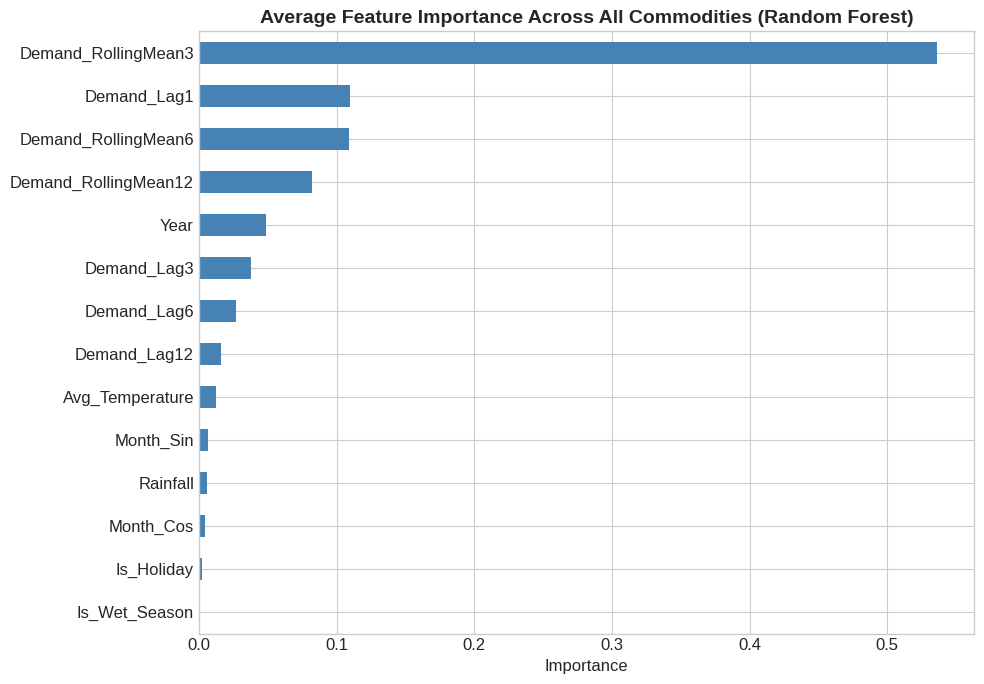


Top 5 most important features:
  Year: 0.0491
  Demand_RollingMean12: 0.0825
  Demand_RollingMean6: 0.1092
  Demand_Lag1: 0.1100
  Demand_RollingMean3: 0.5362


In [ ]:
# ============================================================
# Cell 15: Feature Importance (averaged from Random Forest)
# ============================================================

importance_dfs = []
for commodity, output in all_crop_outputs.items():
    fi = output['feature_importance']
    fi_df = pd.DataFrame([fi])
    fi_df['Commodity'] = commodity
    importance_dfs.append(fi_df)

if importance_dfs:
    all_importance = pd.concat(importance_dfs, ignore_index=True)
    avg_importance = all_importance[FEATURE_COLS].mean().sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(10, 7))
    avg_importance.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Average Feature Importance Across All Commodities (Random Forest)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print('\nTop 5 most important features:')
    for feat, imp in avg_importance.tail(5).items():
        print(f'  {feat}: {imp:.4f}')

## 6. Export Results for Report

In [ ]:
# ============================================================
# Cell 16: Export Results
# ============================================================

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
champion_df.to_csv('champion_models.csv', index=False)

print('Results saved:')
print('  - model_comparison_results.csv  (full RMSE & MAPE per commodity per model)')
print('  - champion_models.csv           (best model per commodity)')

# Download files
from google.colab import files
files.download('model_comparison_results.csv')
files.download('champion_models.csv')

Results saved:
  - model_comparison_results.csv  (full RMSE & MAPE per commodity per model)
  - champion_models.csv           (best model per commodity)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>